In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [2]:

data_dict = {"PPI: All Comodities": "PPIACO",
             "PPI: Lumber and Wood Products":"WPU081",
            "PPI: Copper and Copper Products":"WPUSI019011",
            "PPI: Gas and Oil Extraction":"PCU21112111",
            "Expected Inflation: 5 Year Breakeven Rate":"T5YIE",
            "CPI: Urban Consumption":"CPIAUCSL",
            "Industrial Production Index":"INDPRO",
            "5 Year Breakeven Inflation Rate":"T5YIE",
            "M2":"WM2NS"}
freq = "M"
start = datetime.datetime(2000, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

df = gather_data(data_dict, start, 
          end = end, freq = freq)

In [3]:
keys = df.keys()
for key in keys:
    if "PPI" in key or "CPI" in key or "M2" in key:
        df[key + " Annual % Change"] = df[key].pct_change(12) * 100
df

,PPI: All Comodities,PPI: Lumber and Wood Products,PPI: Copper and Copper Products,PPI: Gas and Oil Extraction,Expected Inflation: 5 Year Breakeven Rate,CPI: Urban Consumption,Industrial Production Index,5 Year Breakeven Inflation Rate,M2,PPI: All Comodities Annual % Change,PPI: Lumber and Wood Products Annual % Change,PPI: Copper and Copper Products Annual % Change,PPI: Gas and Oil Extraction Annual % Change,CPI: Urban Consumption Annual % Change,M2 Annual % Change
DATE,,,,,,,,,,,,,,,
2000-01-31,128.3,189.1,133.9,94.2,NaN,169.300,91.7942,NaN,4674.980,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,129.8,189.2,133.3,102.6,NaN,170.000,92.1272,NaN,4674.400,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,130.8,188.5,130.0,107.0,NaN,171.000,92.4733,NaN,4731.975,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,130.7,186.3,128.5,102.7,NaN,170.900,93.0619,NaN,4815.150,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,131.6,180.3,131.8,109.1,NaN,171.200,93.3427,NaN,4732.500,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,210.6,343.9,463.8,189.1,2.311579,263.161,96.3720,2.311579,19518.425,7.066599,59.804833,28.797556,69.292748,1.675656,26.883498
2021-03-31,216.3,367.1,502.1,187.4,2.496957,264.793,98.9400,2.496957,19925.060,12.014500,65.285907,43.334285,131.072750,2.637322,24.724793
2021-04-30,217.5,388.0,501.1,151.5,2.529545,266.832,98.9660,2.529545,20283.675,17.250674,89.731051,48.210589,177.472527,4.153135,18.778785


In [4]:
# set default fontsize for text in plot
plt.rcParams.update({'font.size': 42})
plt.rcParams['axes.ymargin'] = .05
plt.rcParams['axes.xmargin'] = .05
plot_keys = ["PPI: Lumber and Wood Products Annual % Change",
             "PPI: Copper and Copper Products Annual % Change",
             "PPI: Gas and Oil Extraction Annual % Change"]
plot_df = df[plot_keys]


<ipython-input-1-8ba7c77b1e5b>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


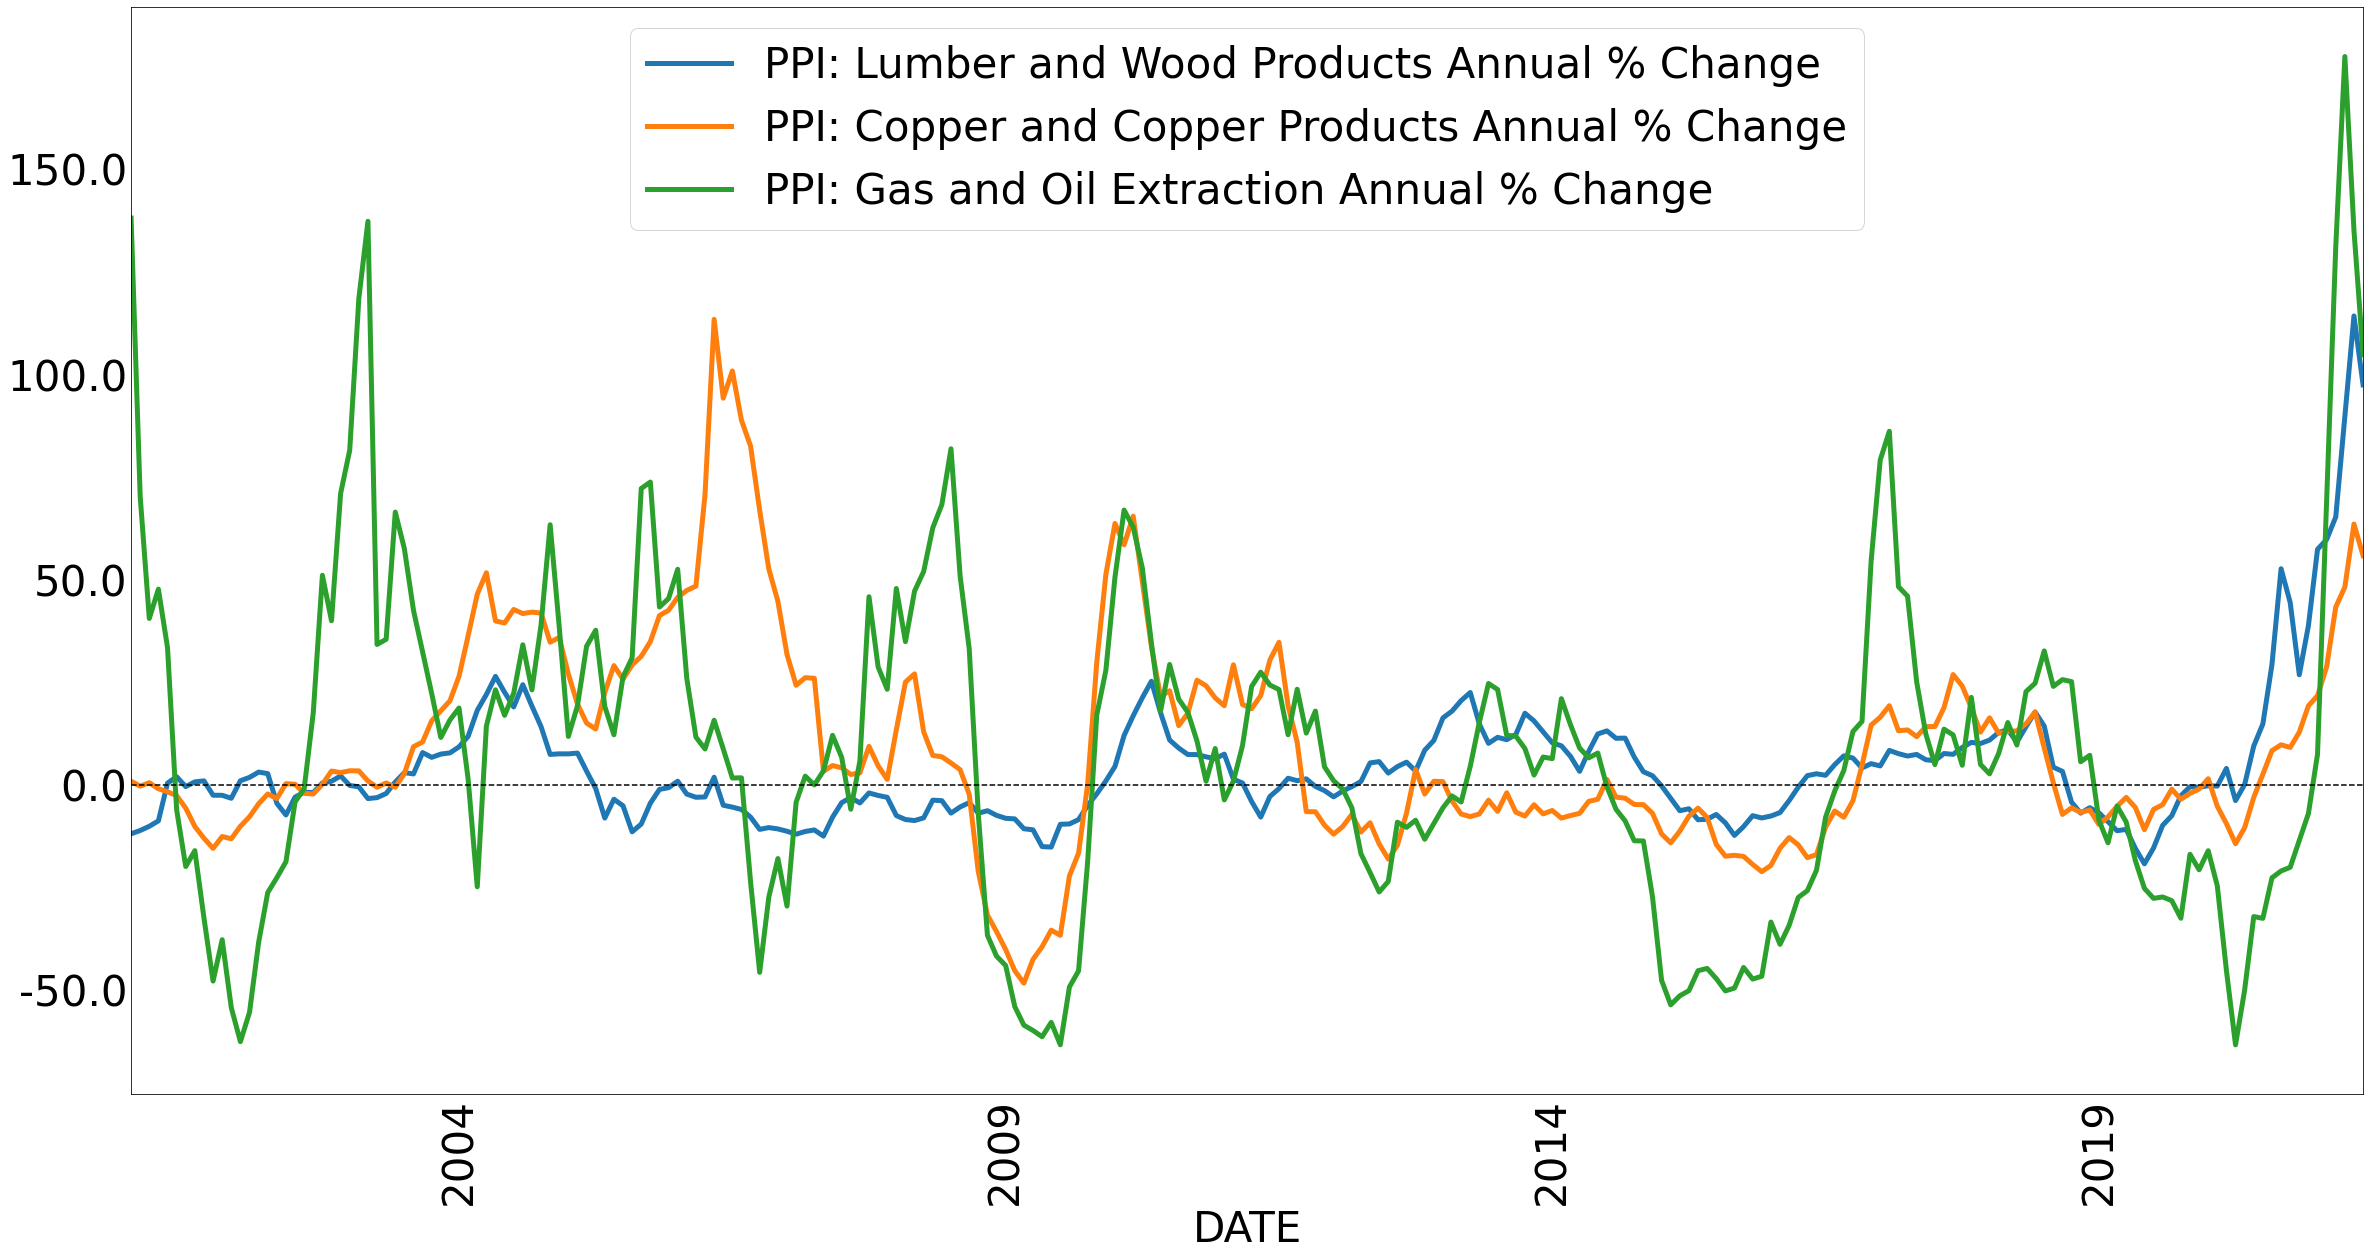

In [5]:
plot_lines(plot_df, linewidth = 5)
plot_df.to_csv("PPIData.csv")

<ipython-input-1-8ba7c77b1e5b>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


,PPI: All Comodities Annual % Change,CPI: Urban Consumption Annual % Change,5 Year Breakeven Inflation Rate
DATE,,,
2000-01-31,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN
...,...,...,...
2021-02-28,7.066599,1.675656,2.311579
2021-03-31,12.014500,2.637322,2.496957
2021-04-30,17.250674,4.153135,2.529545


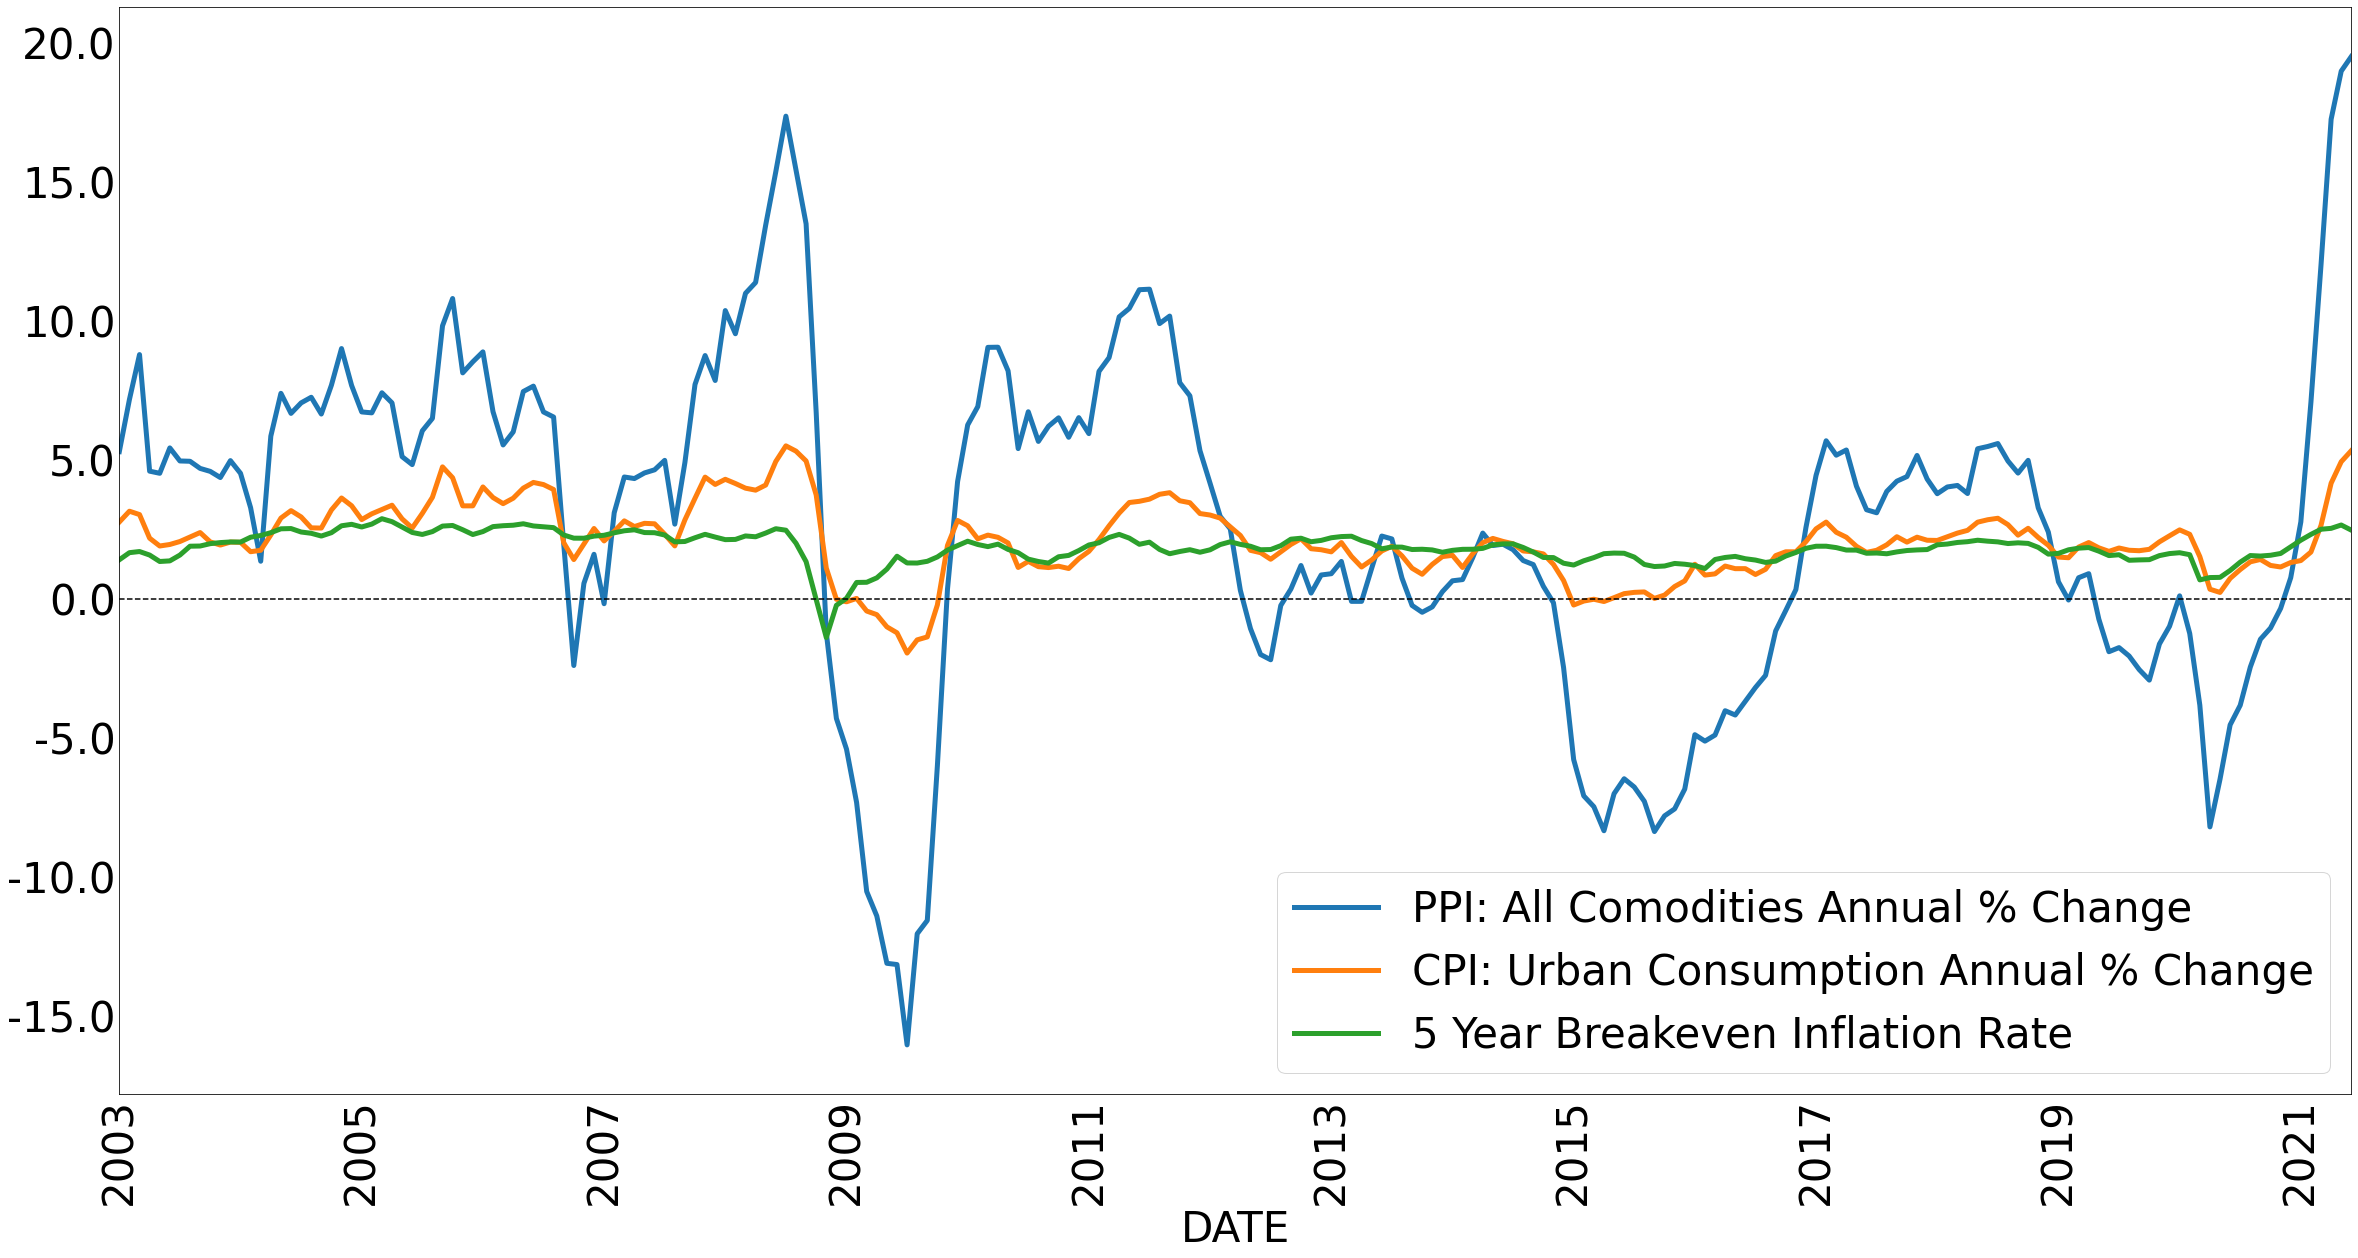

In [6]:
plot_keys = ["PPI: All Comodities Annual % Change", 
             "CPI: Urban Consumption Annual % Change",
             "5 Year Breakeven Inflation Rate"]
plot_df = df[plot_keys]
plot_lines(plot_df, linewidth = 5)
plot_df#.to_csv("inflationData.csv")

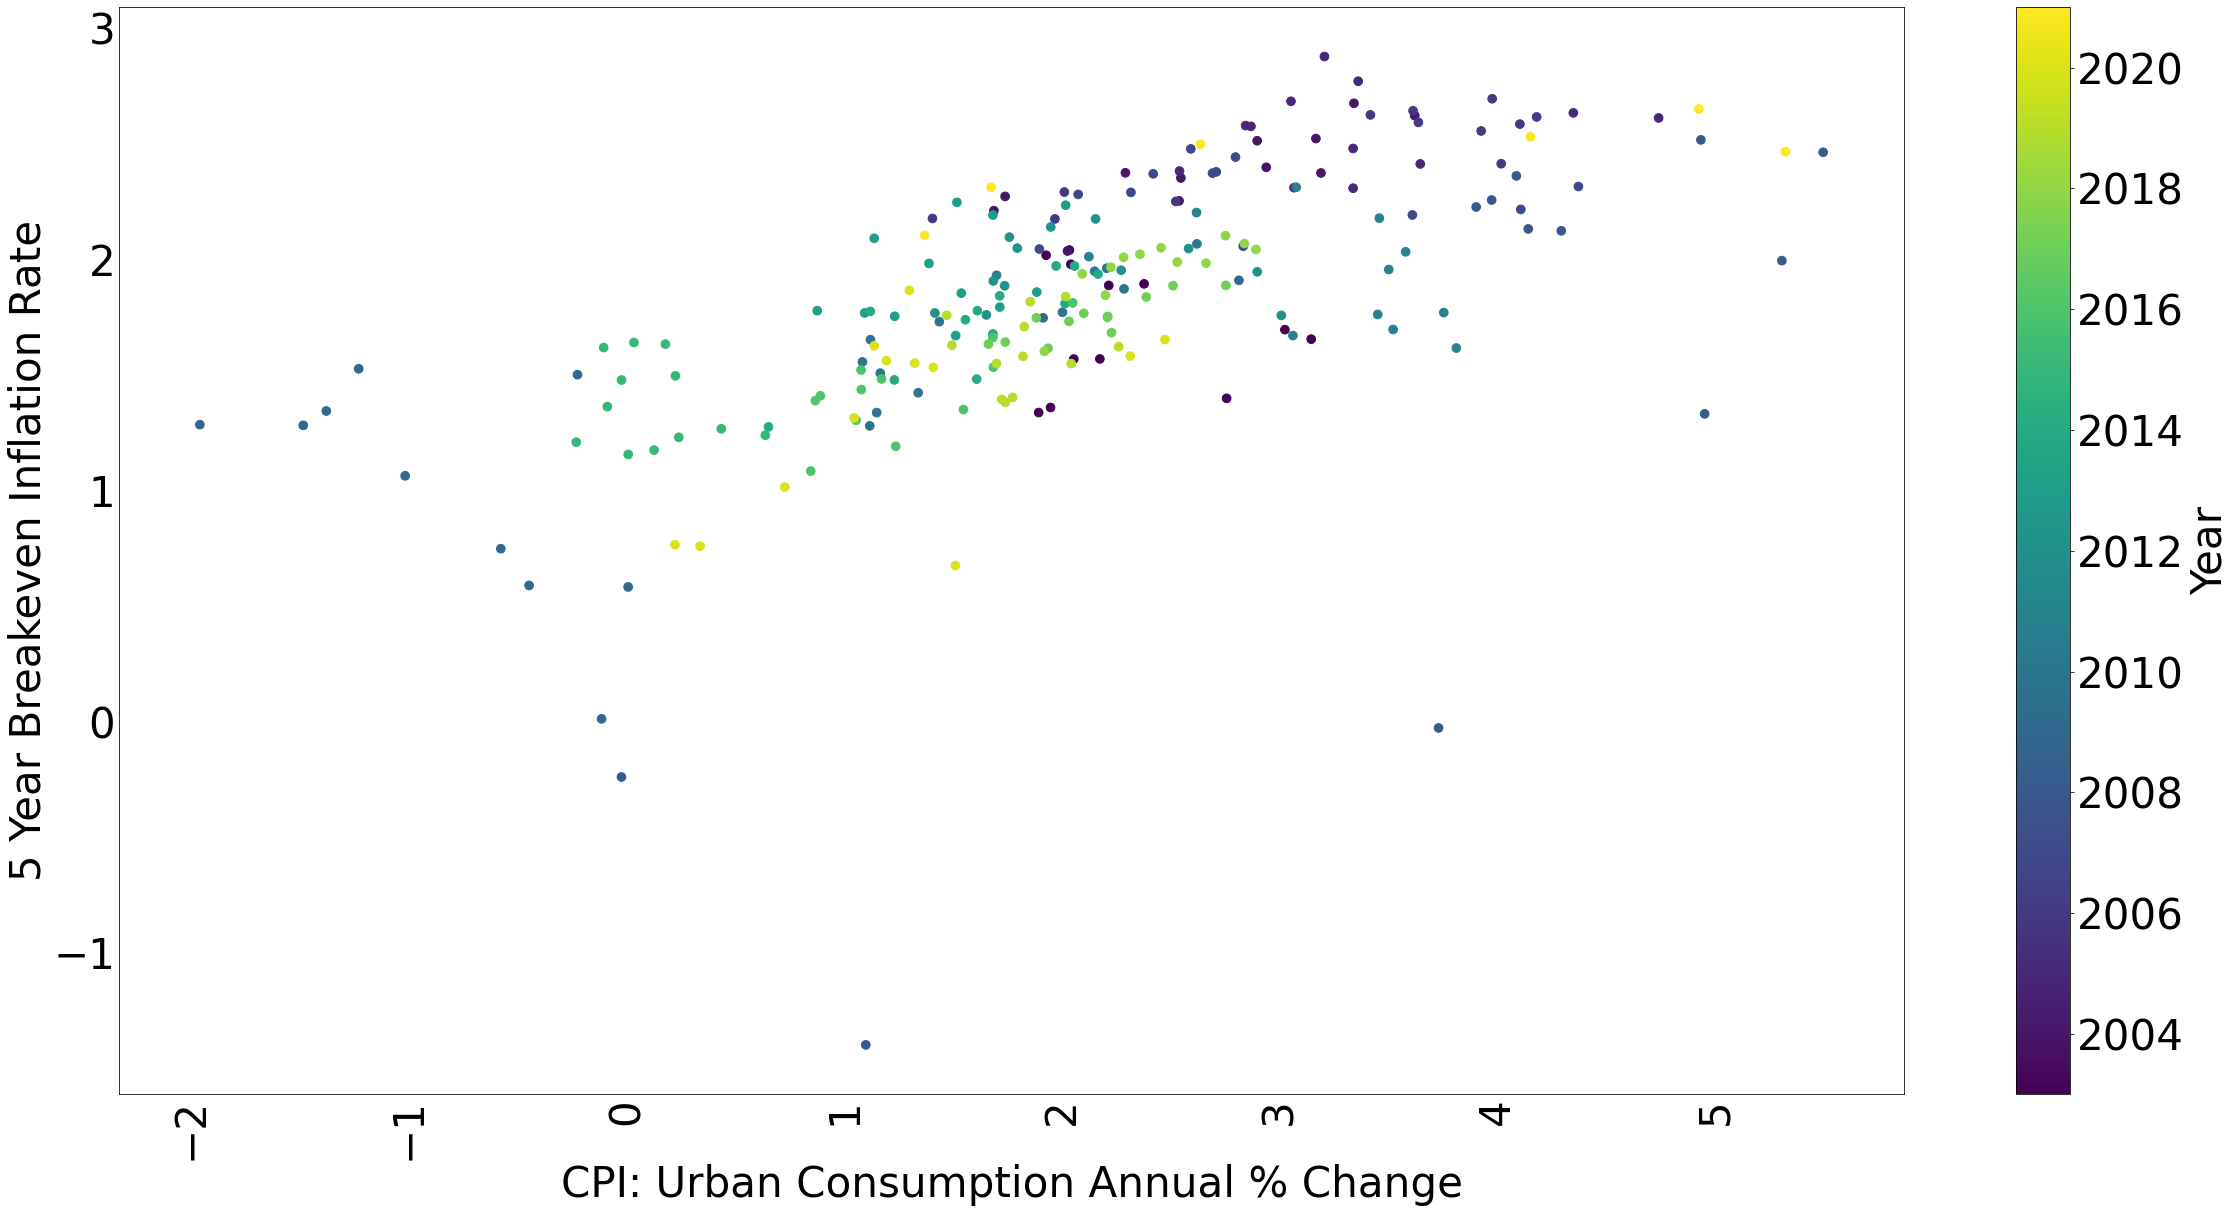

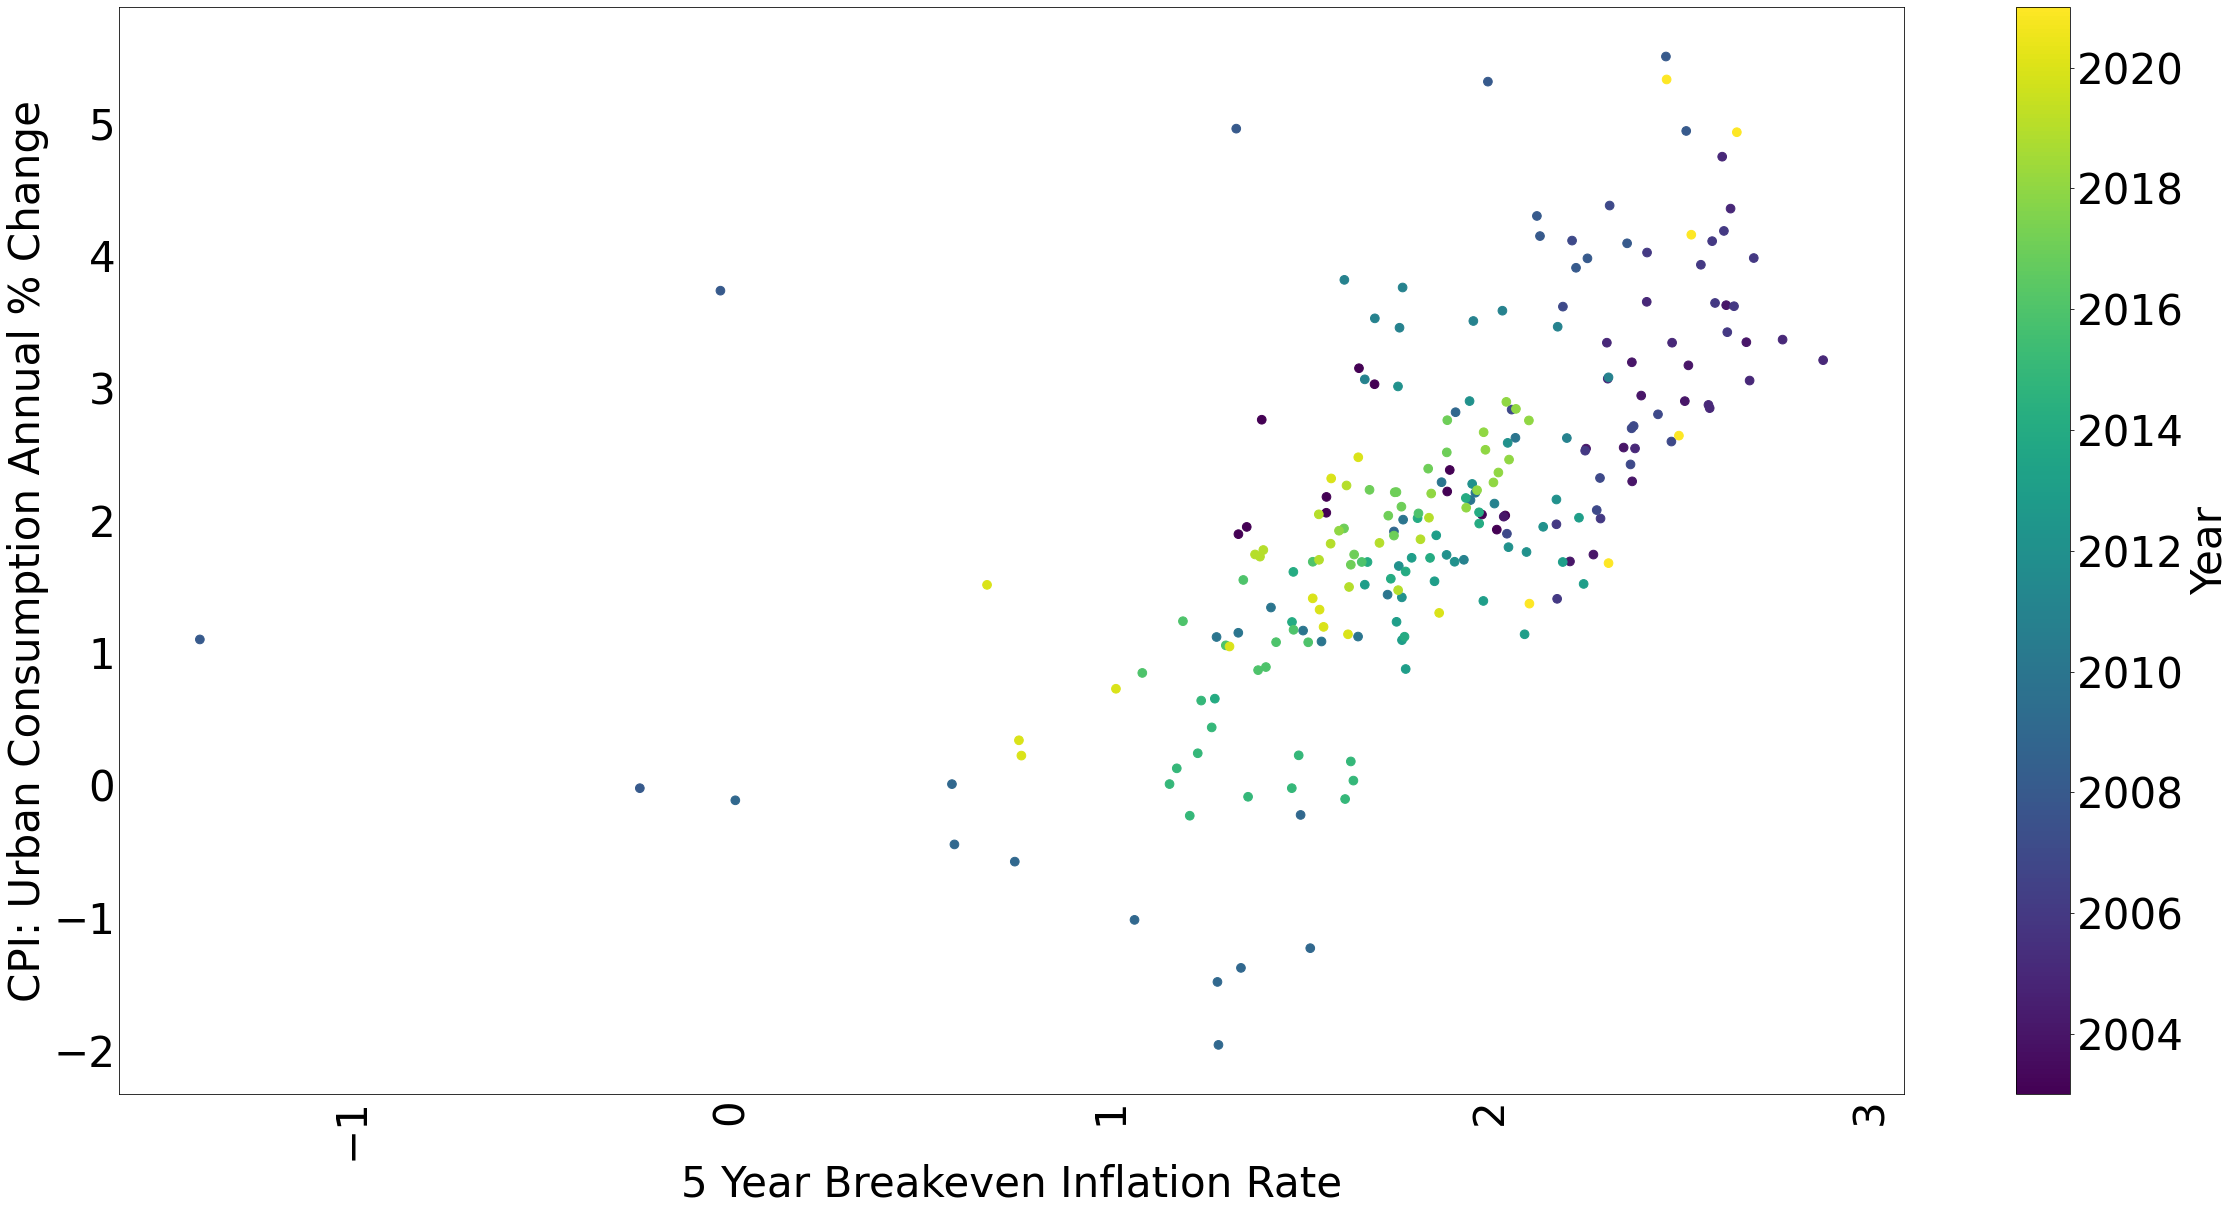

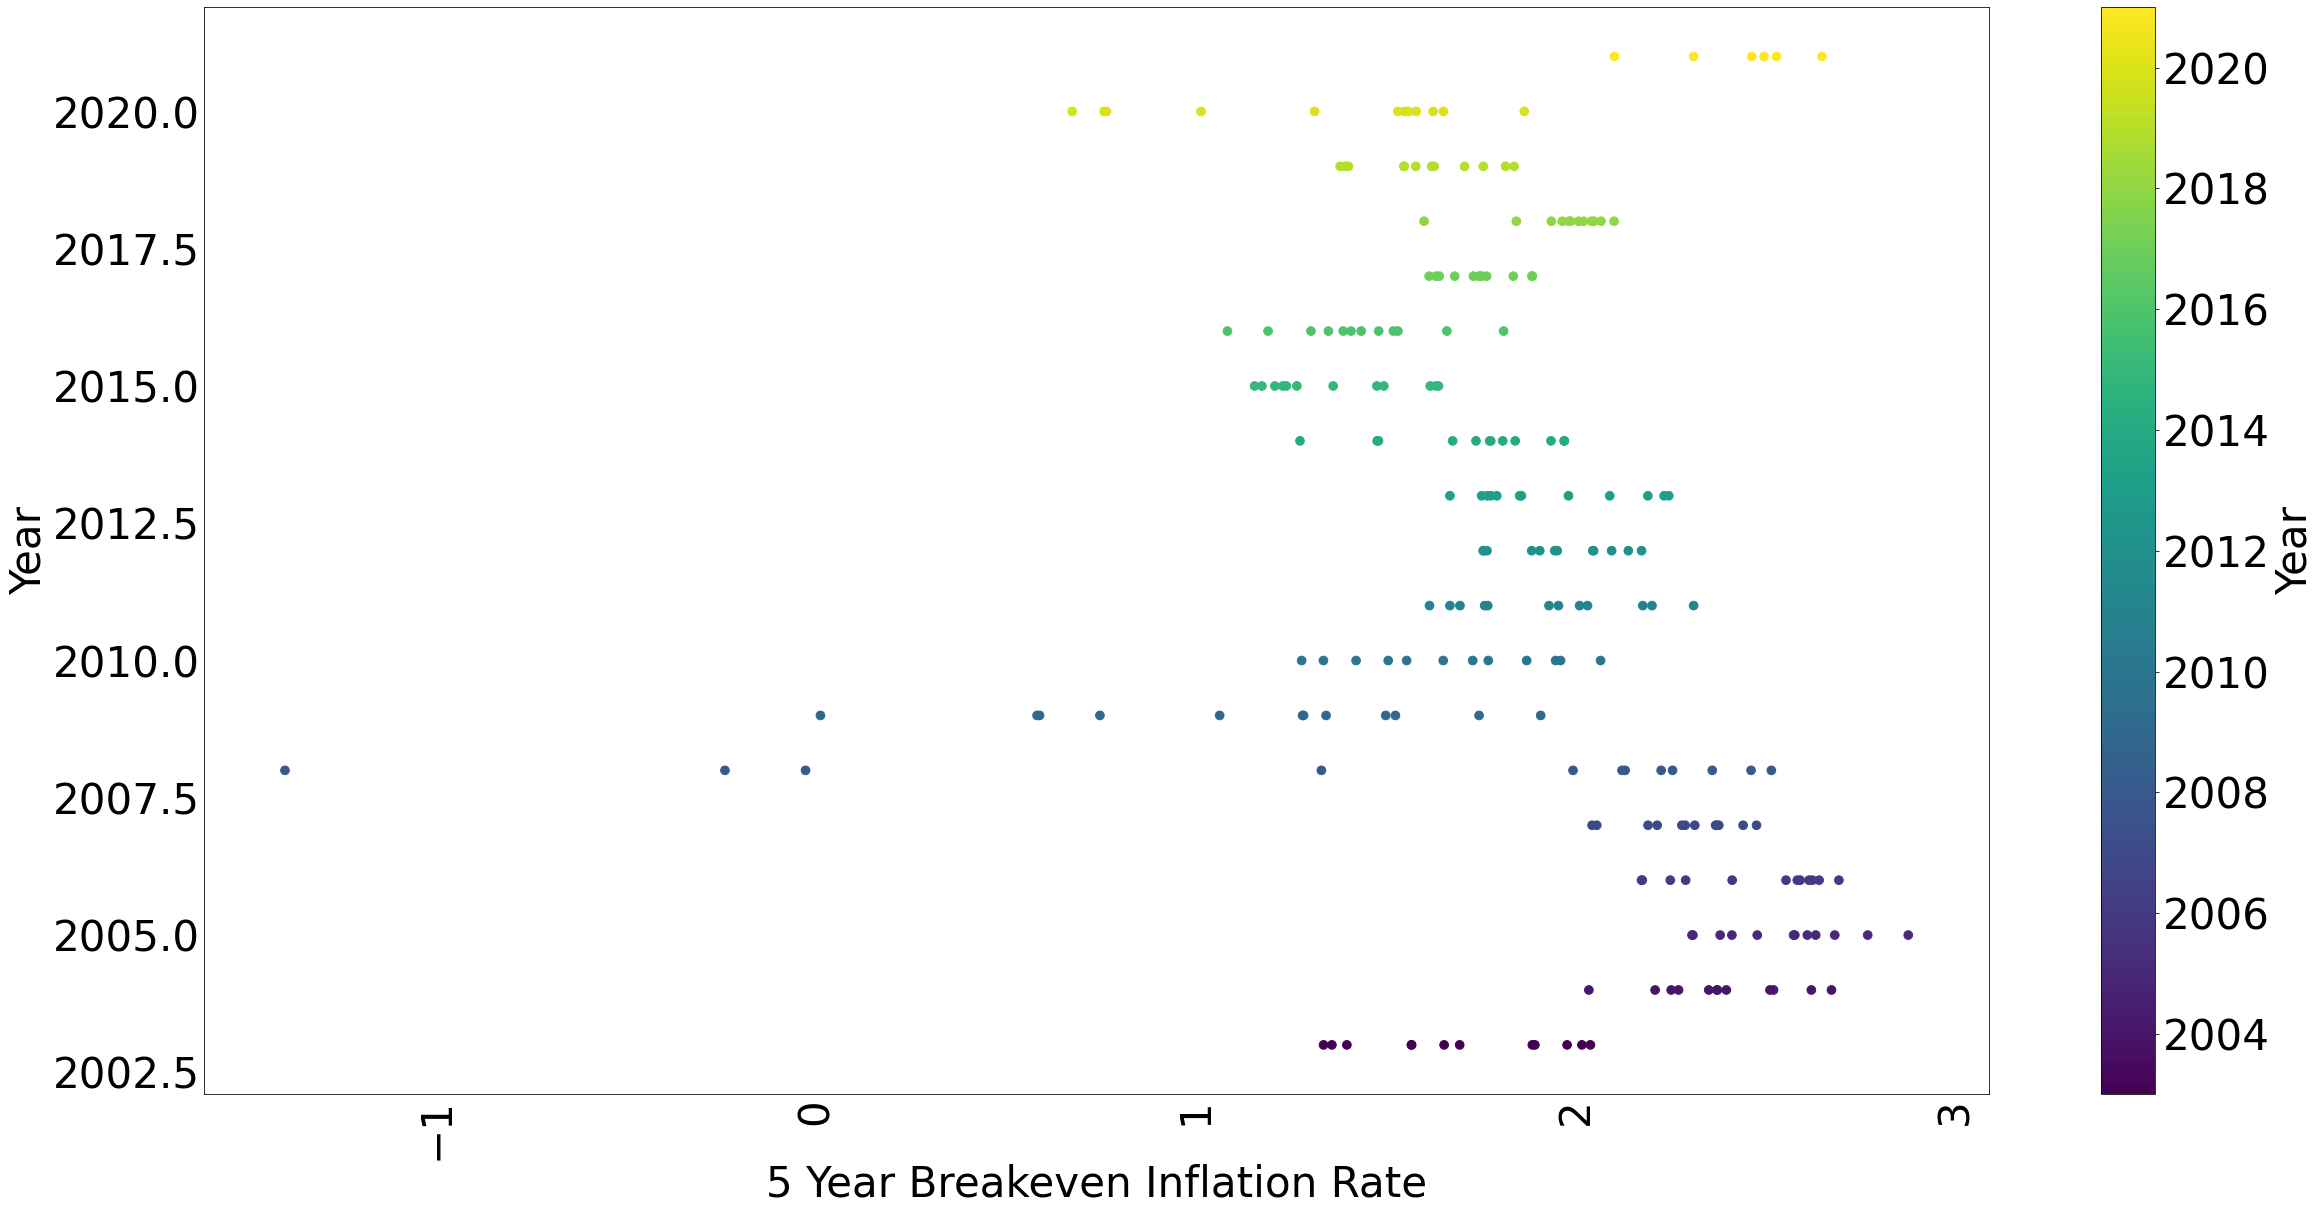

In [7]:
plot_keys=["CPI: Urban Consumption Annual % Change",
           "5 Year Breakeven Inflation Rate"]
plot_df = df[plot_keys]
plot_scatter(plot_df)

<ipython-input-1-8ba7c77b1e5b>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


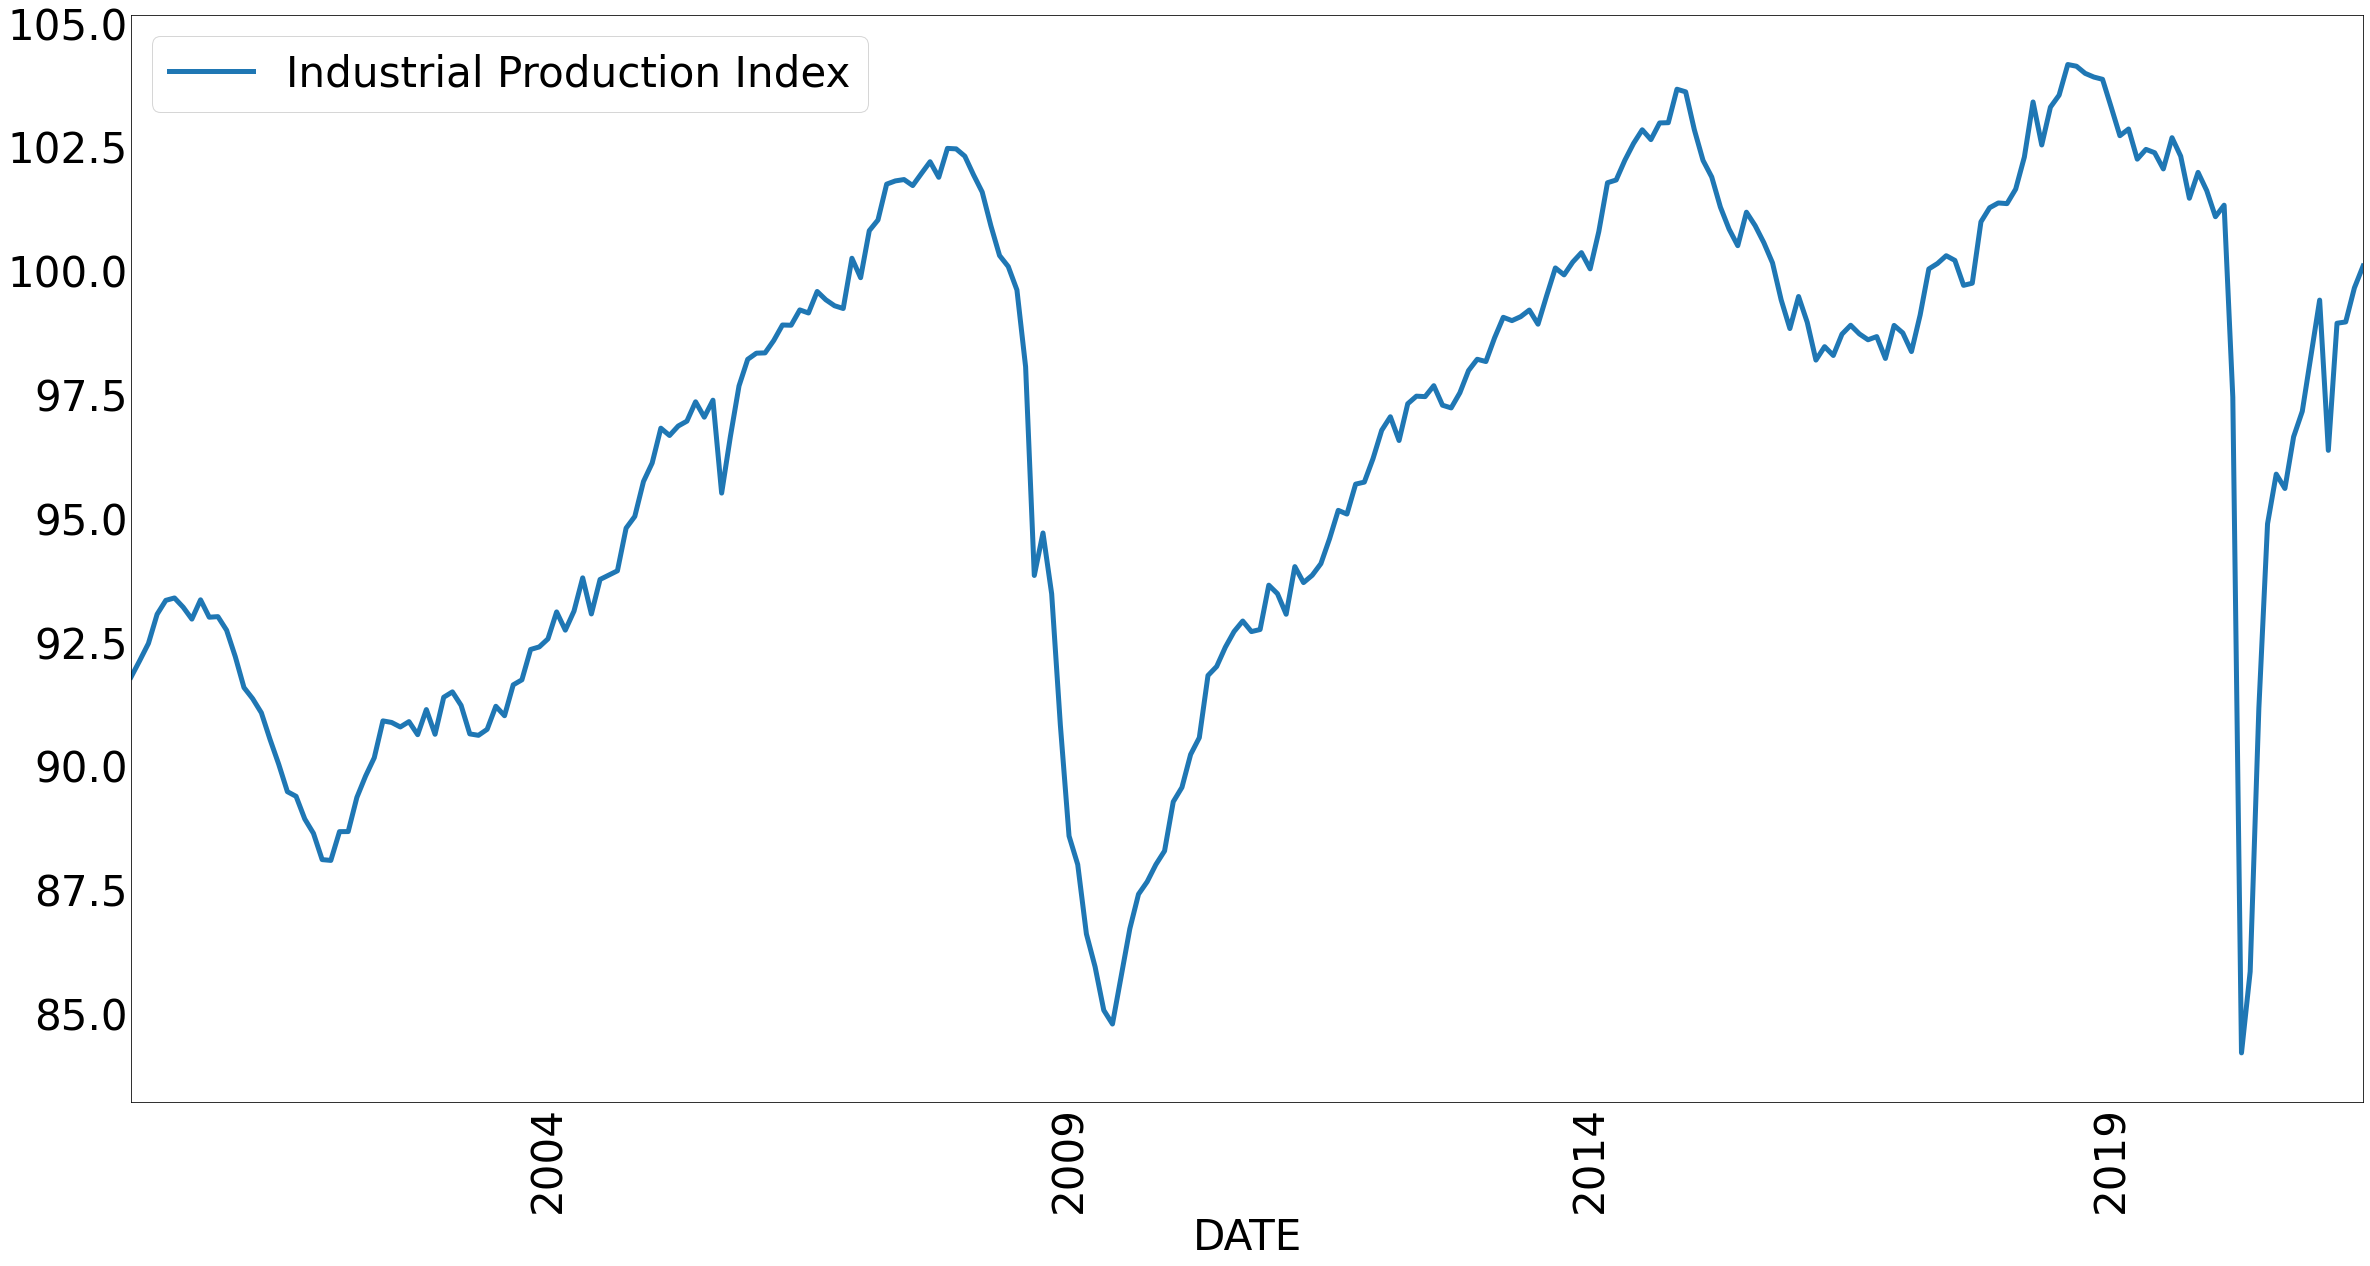

In [8]:
plot_keys = ["Industrial Production Index"]
plot_df = df[plot_keys]
plot_lines(plot_df, linewidth = 5, h_zero = False)
plot_df.to_csv("Industrial Production Index.csv")

<ipython-input-1-8ba7c77b1e5b>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


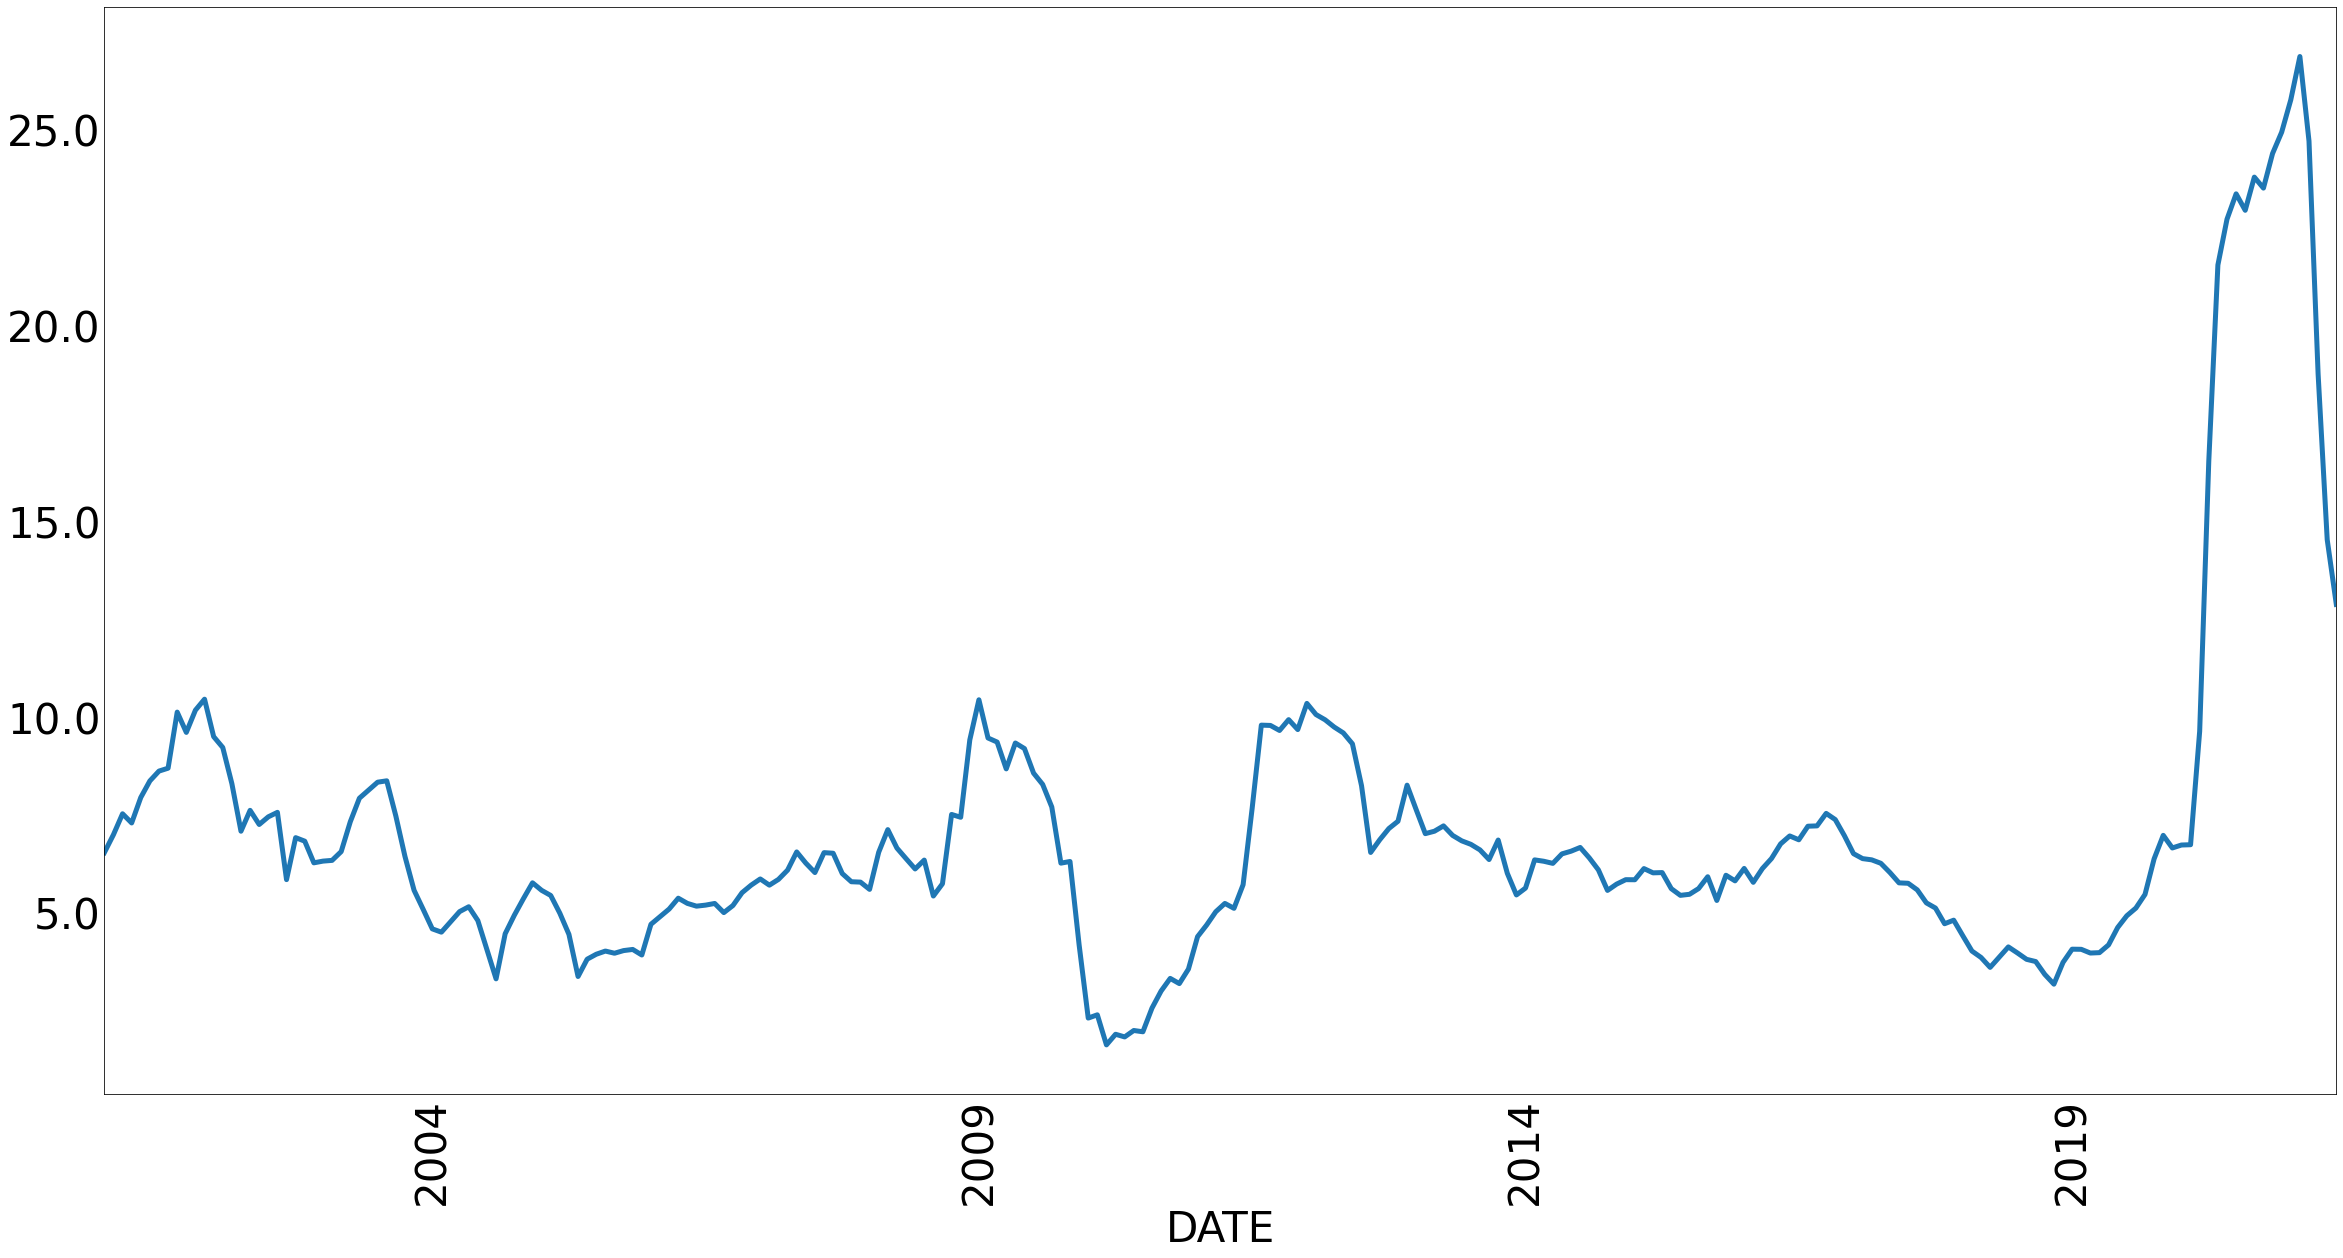

In [9]:
plot_keys = ["M2 Annual % Change"]
plot_df = df[plot_keys]
plot_lines(plot_df, linewidth = 5, h_zero = False, legend = False)
plot_df.to_csv("M2RateData.csv")

In [10]:

data_dict = {"M2 Velocity":"M2V",
             "M2":"M2",
            "Consumer Confidence": "CSCICP03USM665S",
            "NGDP":"GDP",
            "1 Month Treasury Rate":"DGS1MO"}
freq = "Q"
start = datetime.datetime(1970, 1, 1)
#end = datetime.datetime(2020, 12, 31)
end =datetime.datetime.today()

df = gather_data(data_dict, start, 
          end = end, freq = freq)
divisiaAggregates = pd.read_excel("http://centerforfinancialstability.org/amfm/Divisia.xlsx", header = [1], index_col = [0],
                                  parse_dates=True).resample("Q").first()
dkeys = {'Divisia M4 level, normalized to equal 100 in Jan. 1967': "DM4",
   'Divisia M4 year-over-year percentage growth rate':"DM4 YoY % Change",
   'M4 interest-rate aggregate, percent per year': "DM4 Interest Agg", 
   'Divisia M4- level, normalized to equal 100 in Jan. 1967': "DM4-",
   'Divisia M4- year-over-year percentage growth rate':"DM4- YoY % Change",
   'M4- interest-rate aggregate, percent per year': "DM4- Interest Agg", 
   'Divisia M3 level, normalized to equal 100 in Jan. 1967':"DM3",
   'Divisia M3 year-over-year percentage growth rate':"DM3 YoY Change",
   'M3 interest-rate aggregate, percent per year':"DM3 Interest Agg"} 
divisiaAggregates.rename(columns={key:val for key, val in dkeys.items()}, 
                         inplace = True)
for key, val in divisiaAggregates.items():
    df[key] = val.loc["1967":]
df["DM4 Velocity"] = df["DM4"].div(df["NGDP"])
df["DM4 Velocity (normalized)"] = df["DM4 Velocity"].div(df["DM4 Velocity"].iloc[0])
df["DM4- Velocity"] = df["DM4-"].div(df["NGDP"])
df["DM4- Velocity (normalized)"] = df["DM4- Velocity"].div(df["DM4- Velocity"].iloc[0])



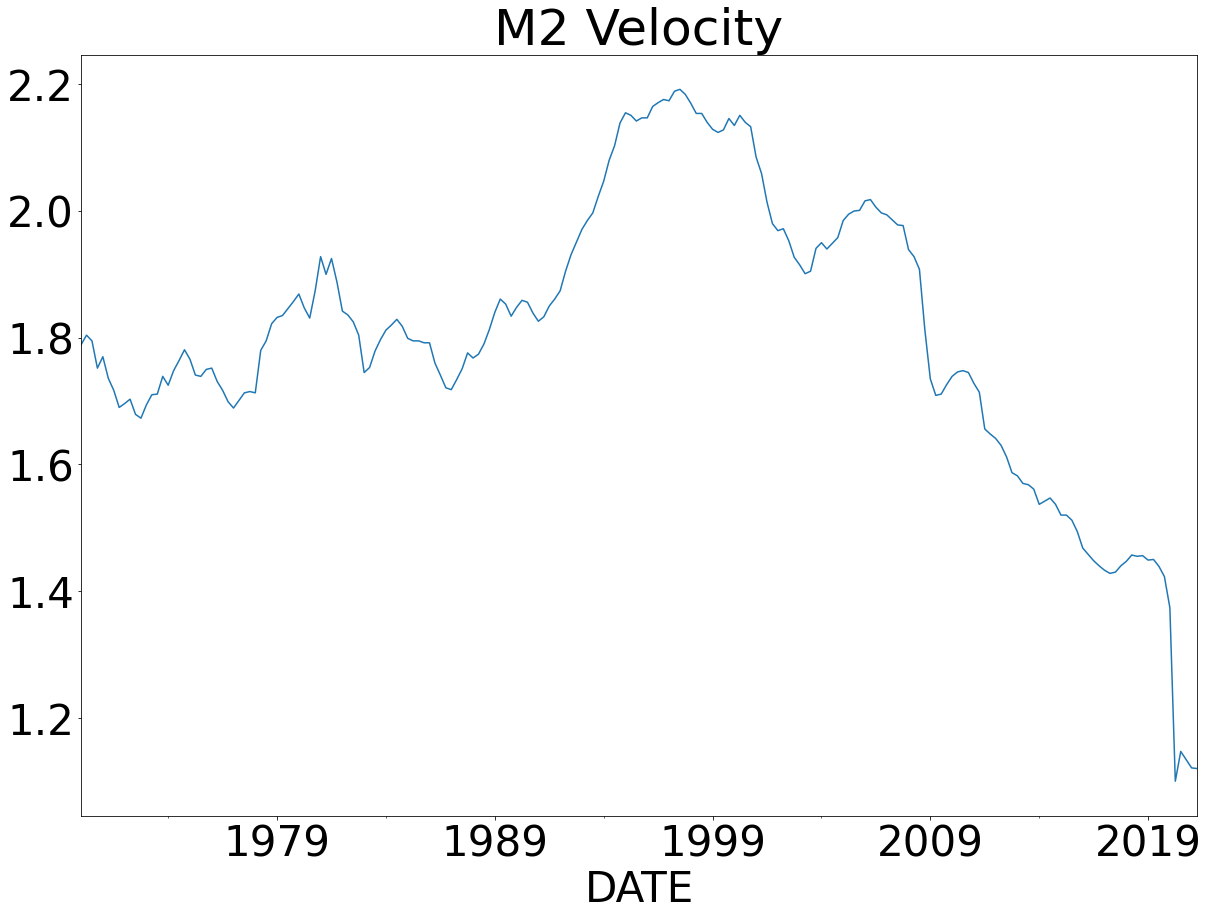

In [11]:
fig, ax = plt.subplots(figsize = (20, 14))
df[["M2 Velocity"]].plot.line(ax = ax, legend = False)
ax.set_title("M2 Velocity")
df[["M2 Velocity"]].to_csv("M2Velocity.csv")

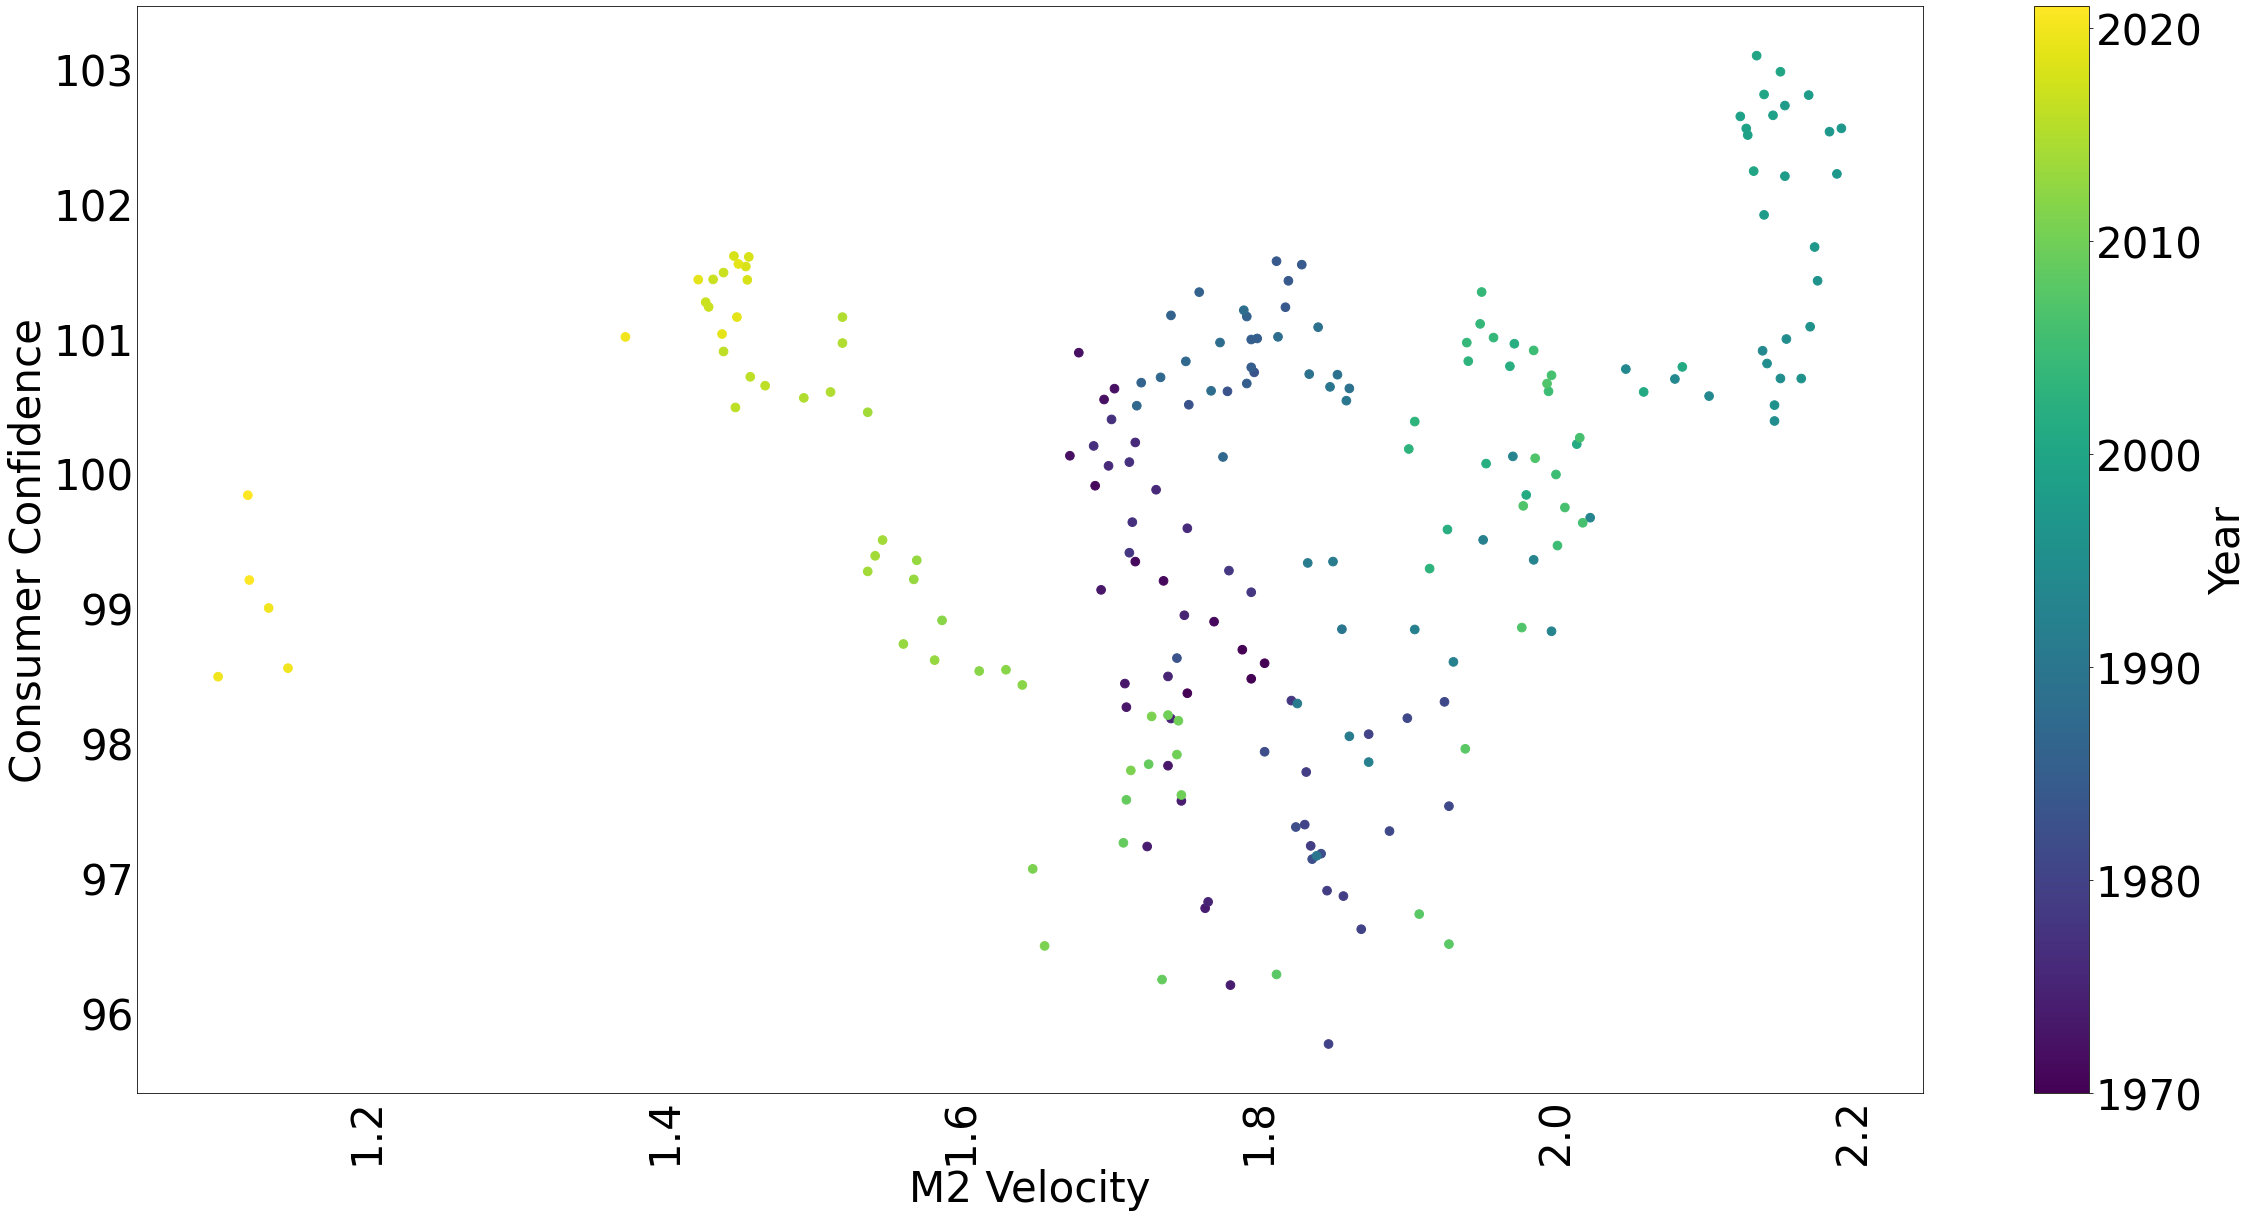

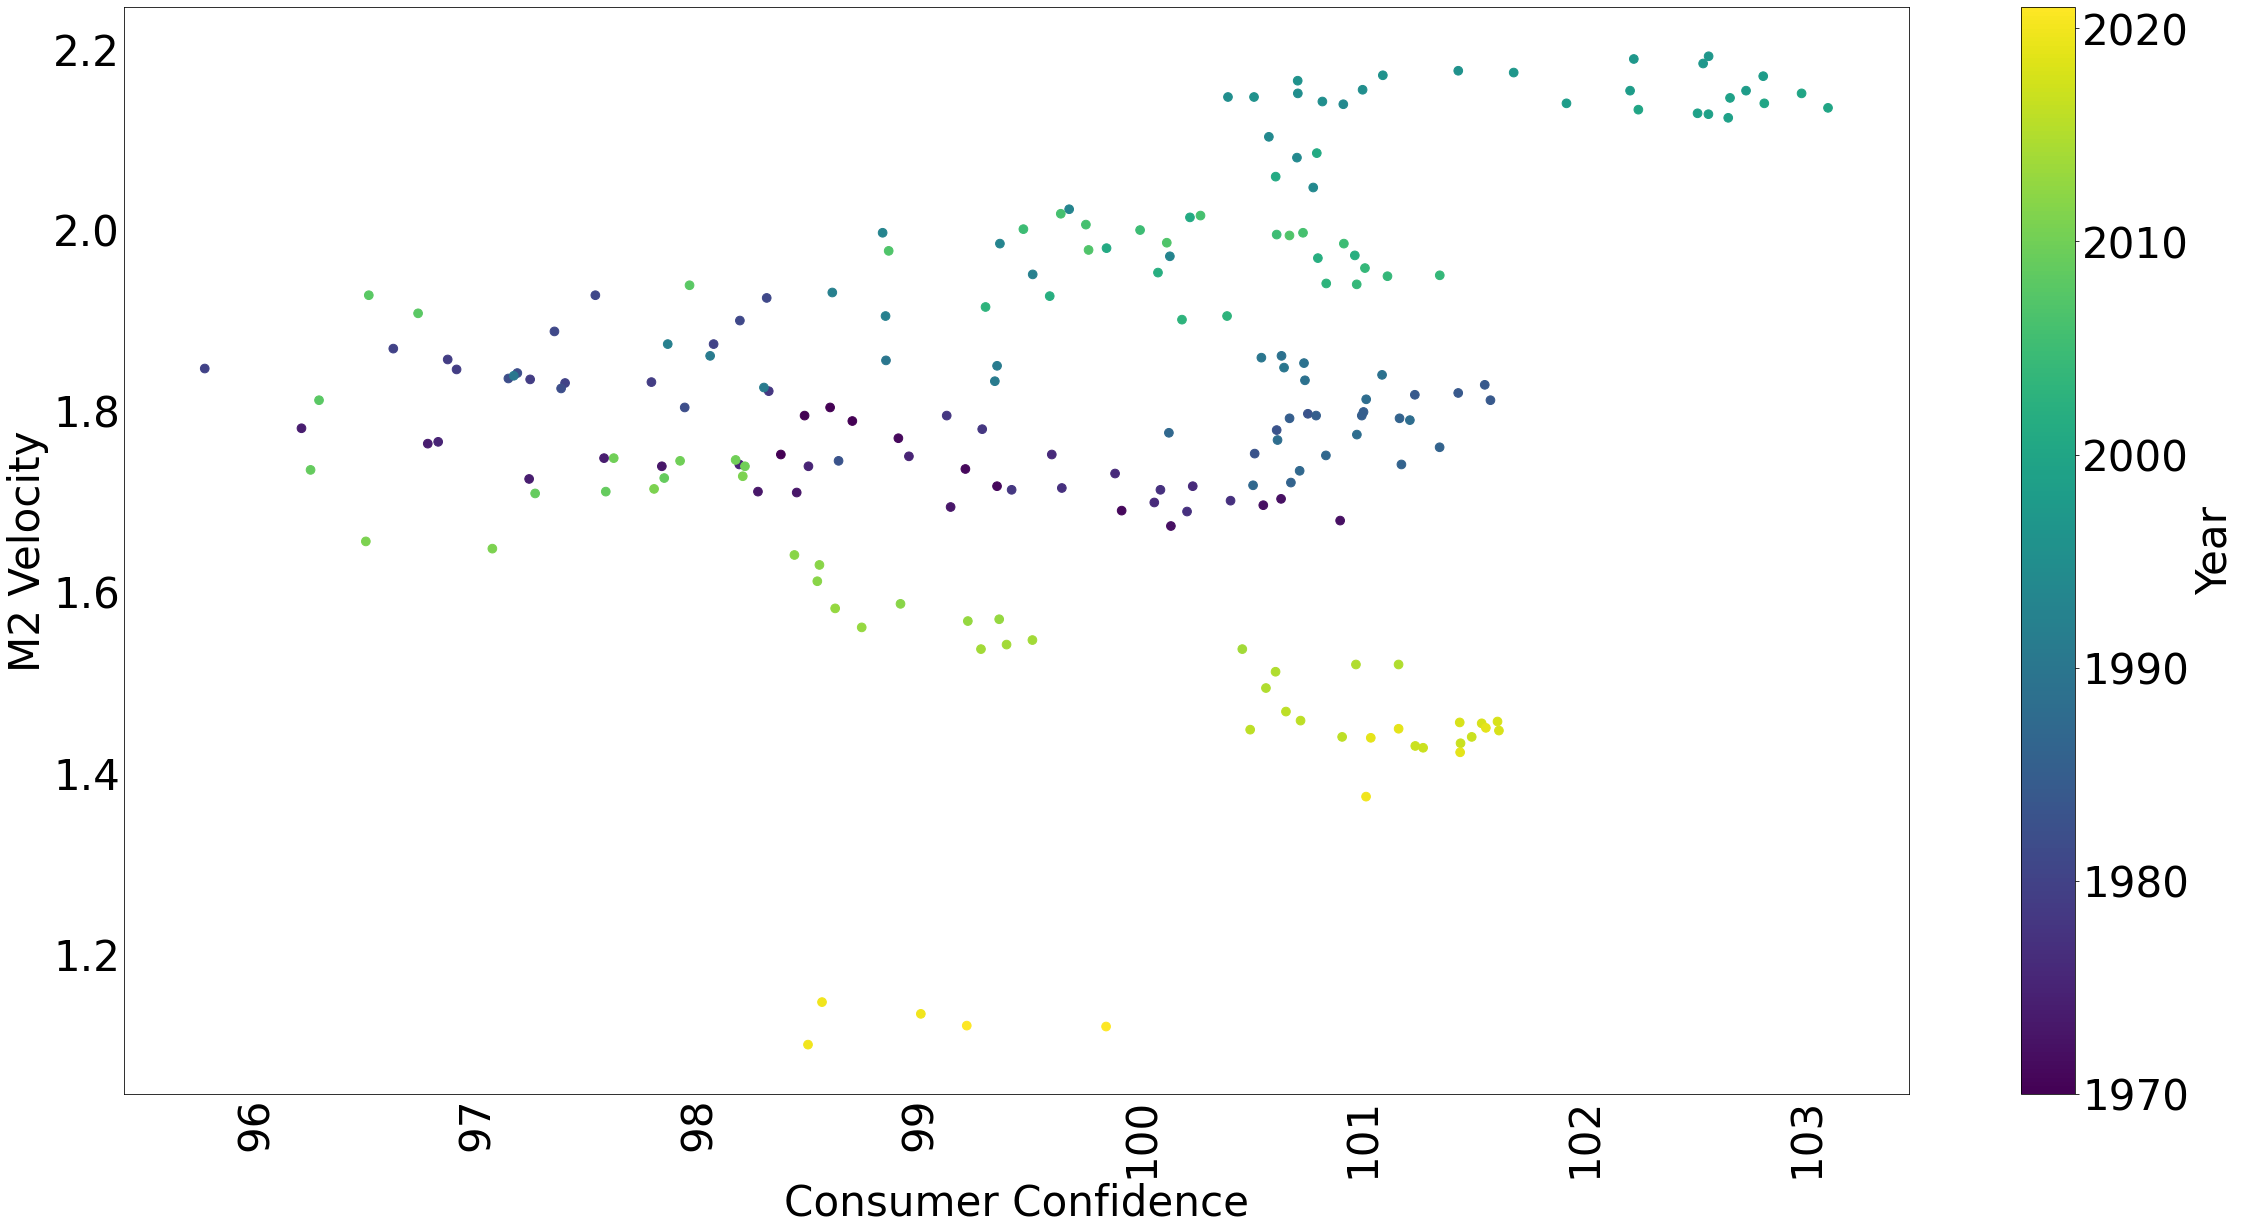

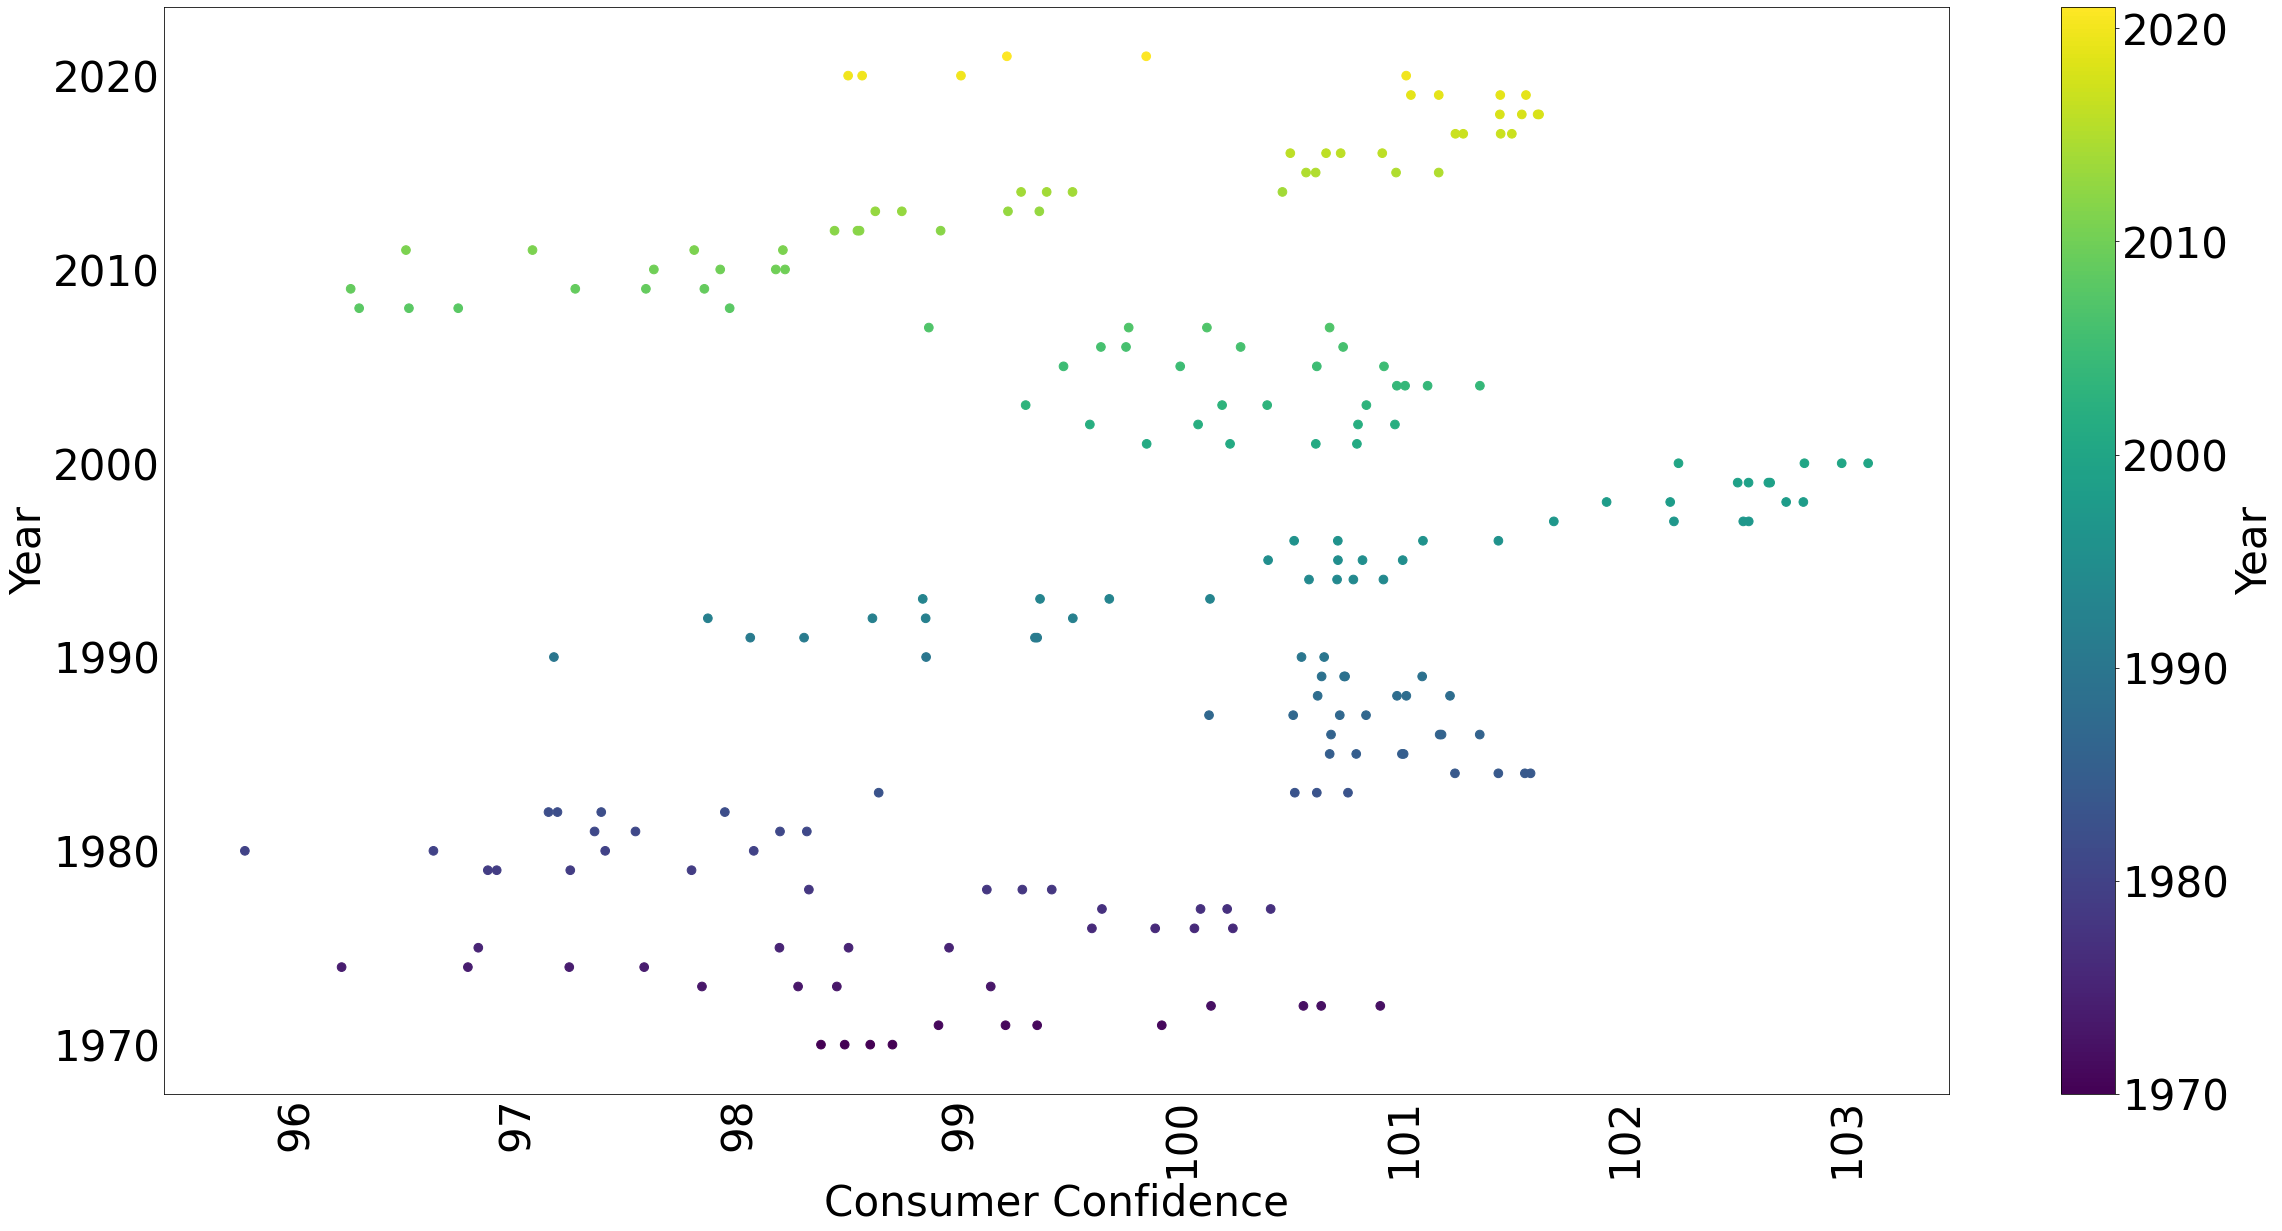

In [12]:
plot_keys = ["M2 Velocity", "Consumer Confidence"]
plot_df = df[plot_keys]
plot_scatter(plot_df)

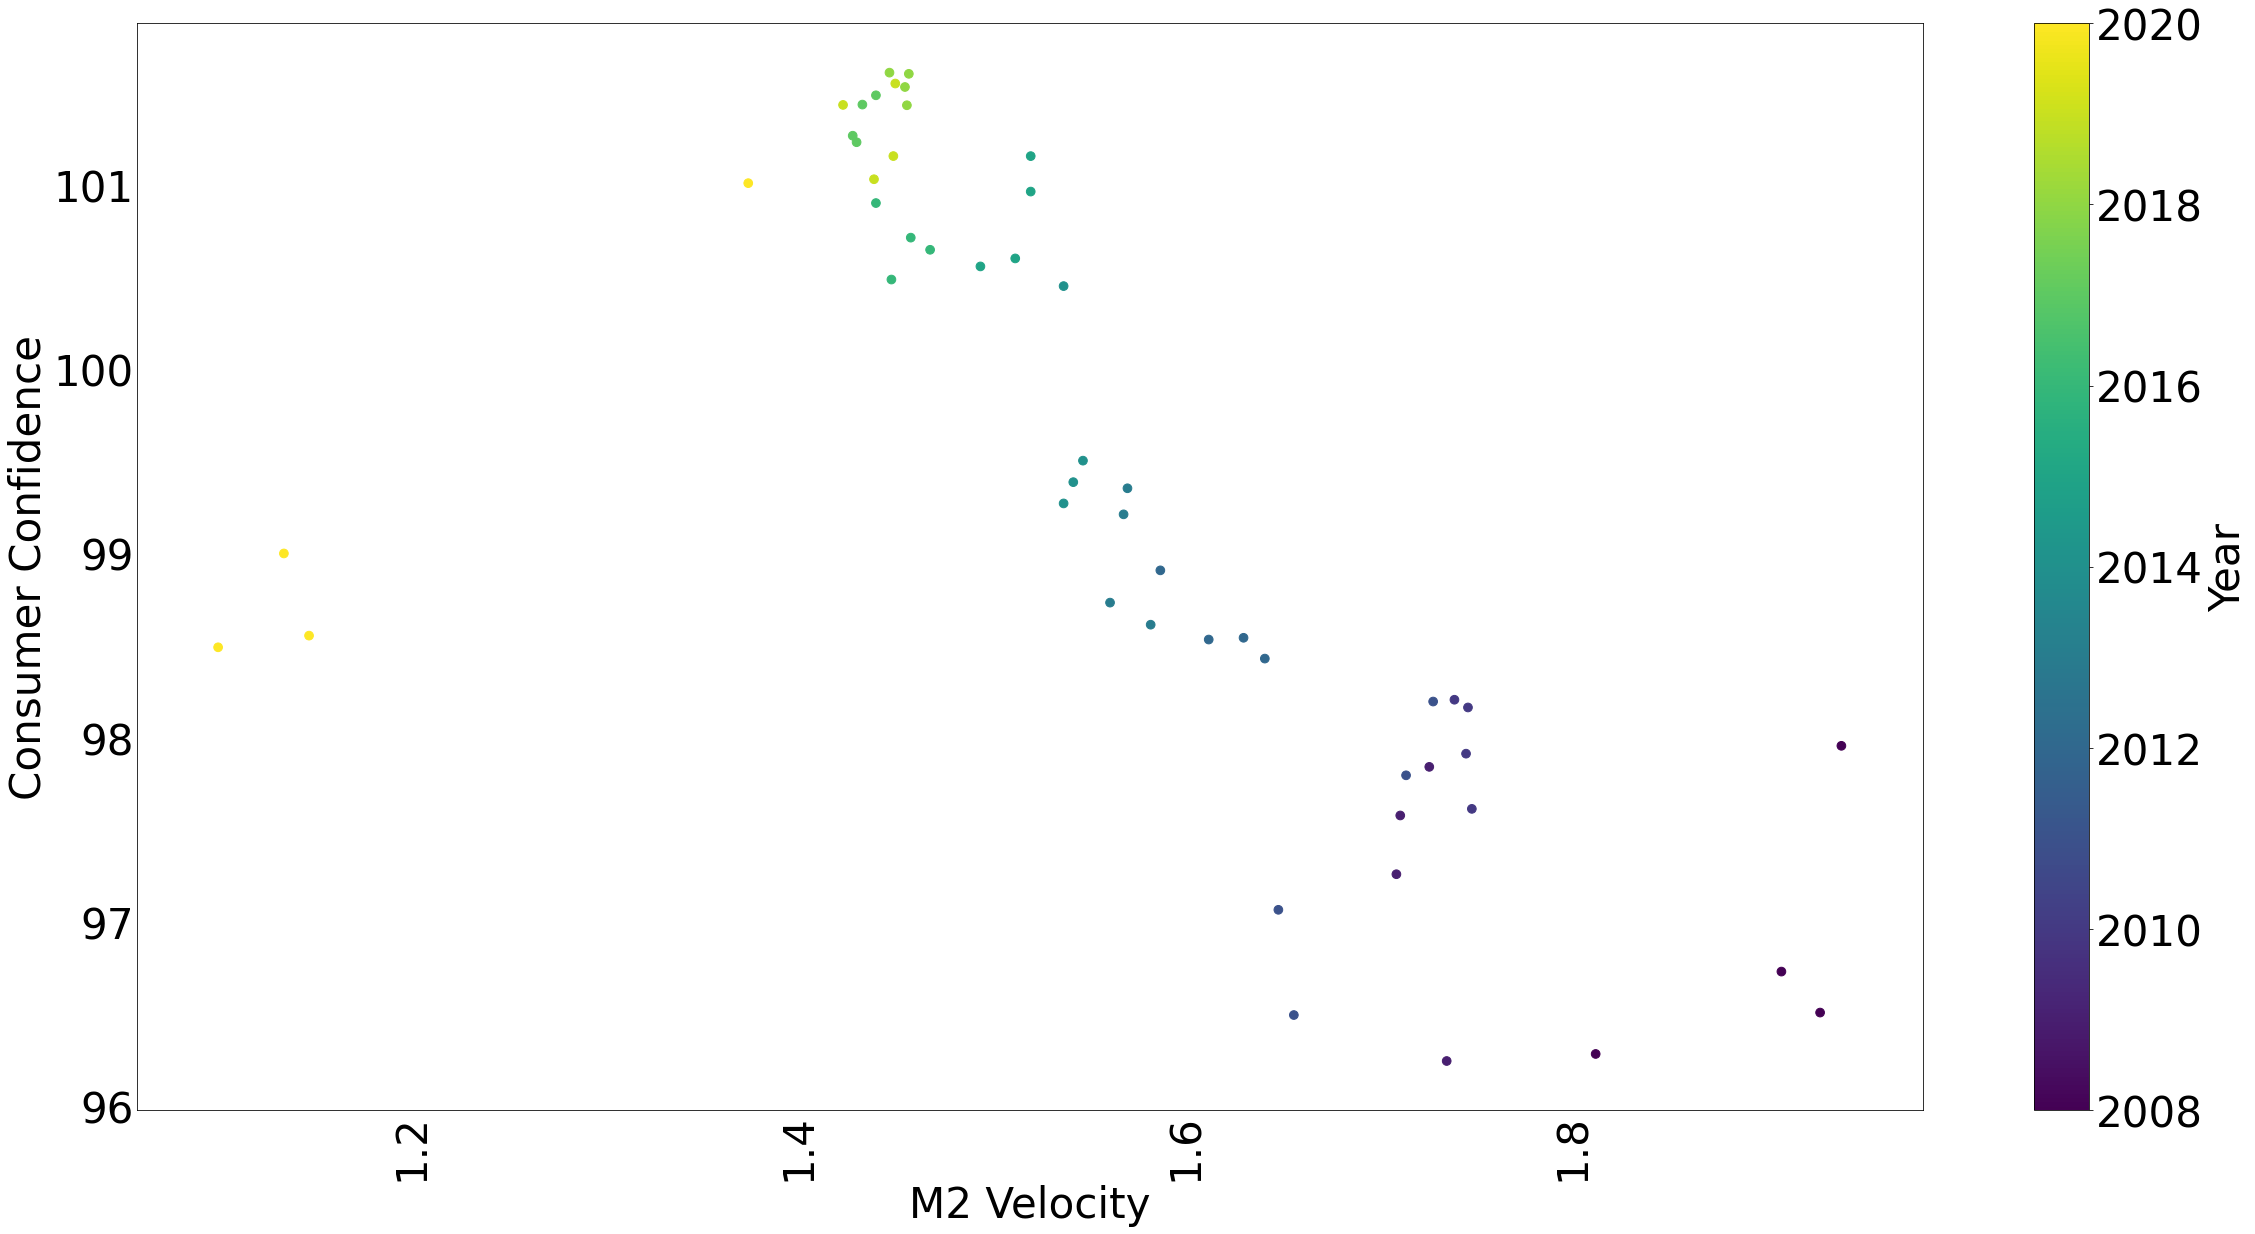

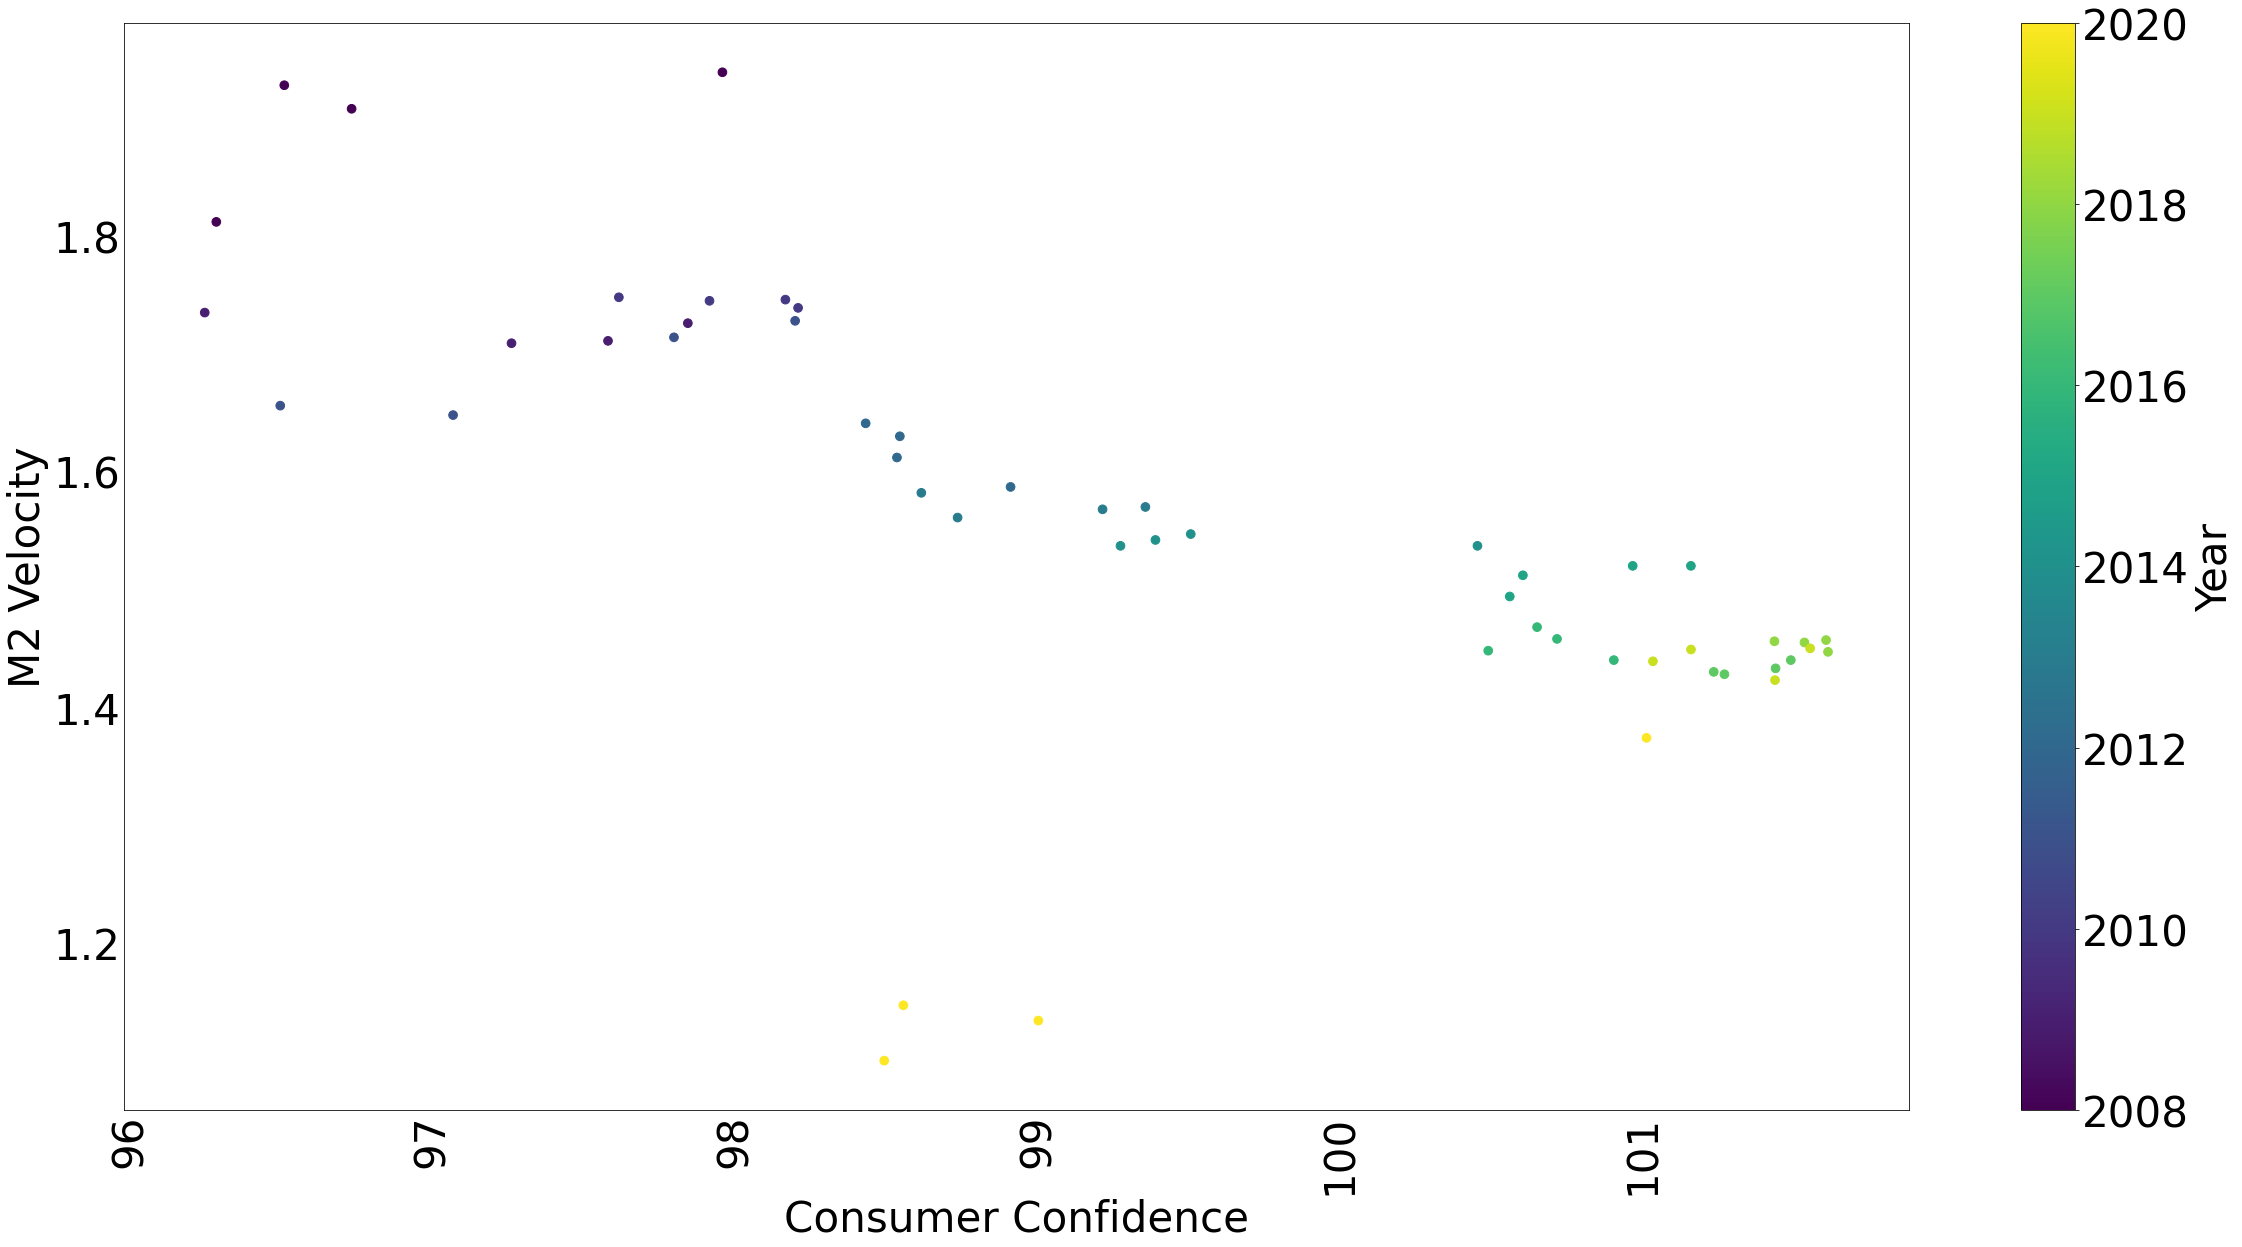

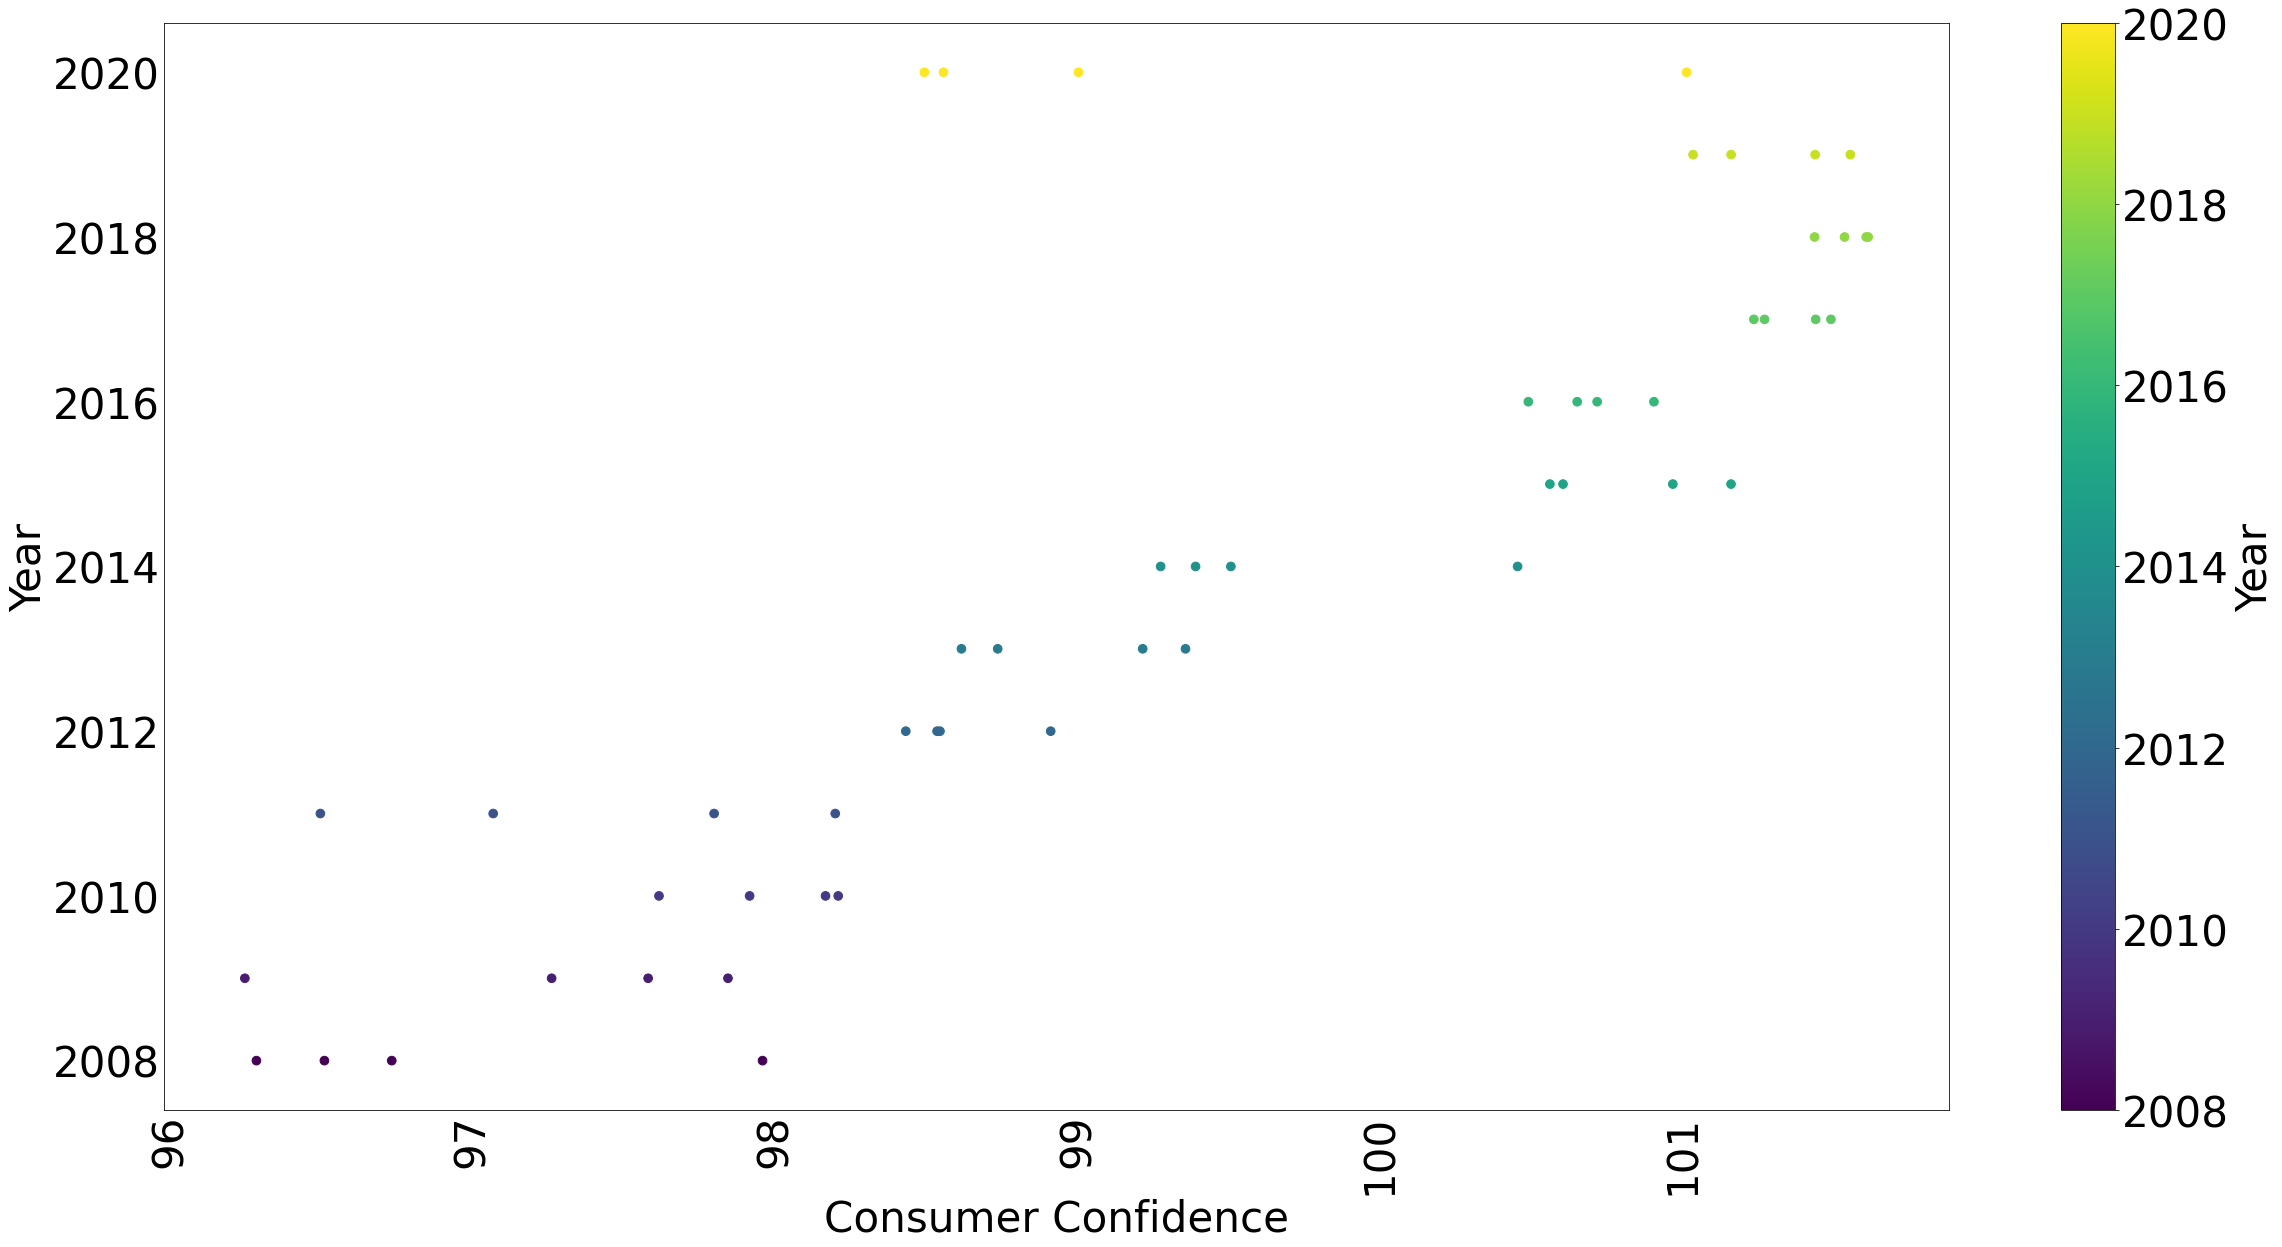

In [13]:
plot_df = df[plot_keys].loc["2008":"2020"]
plot_scatter(plot_df)

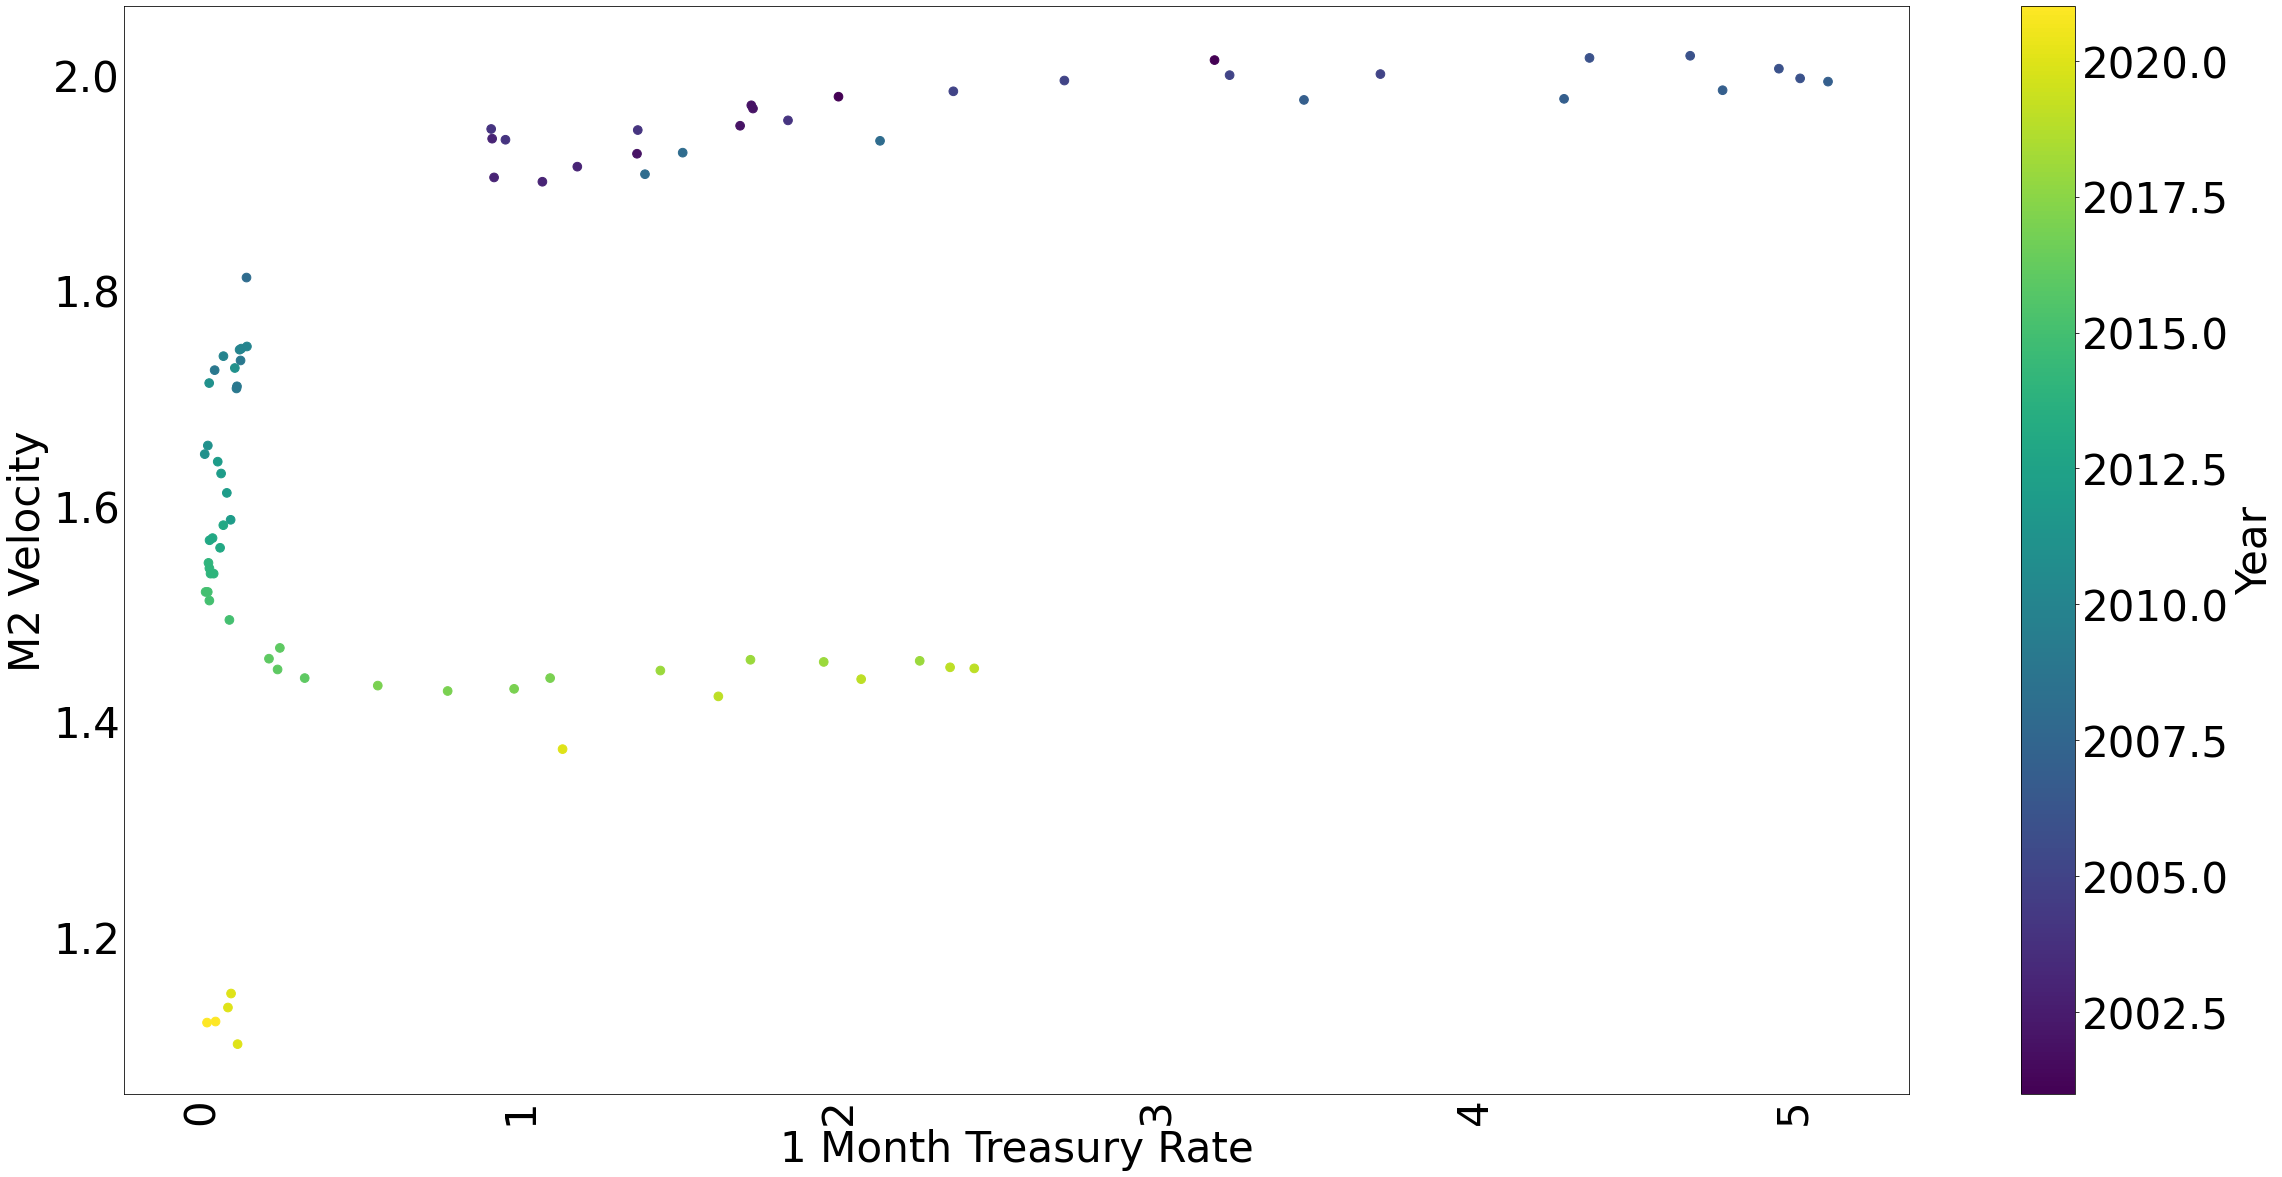

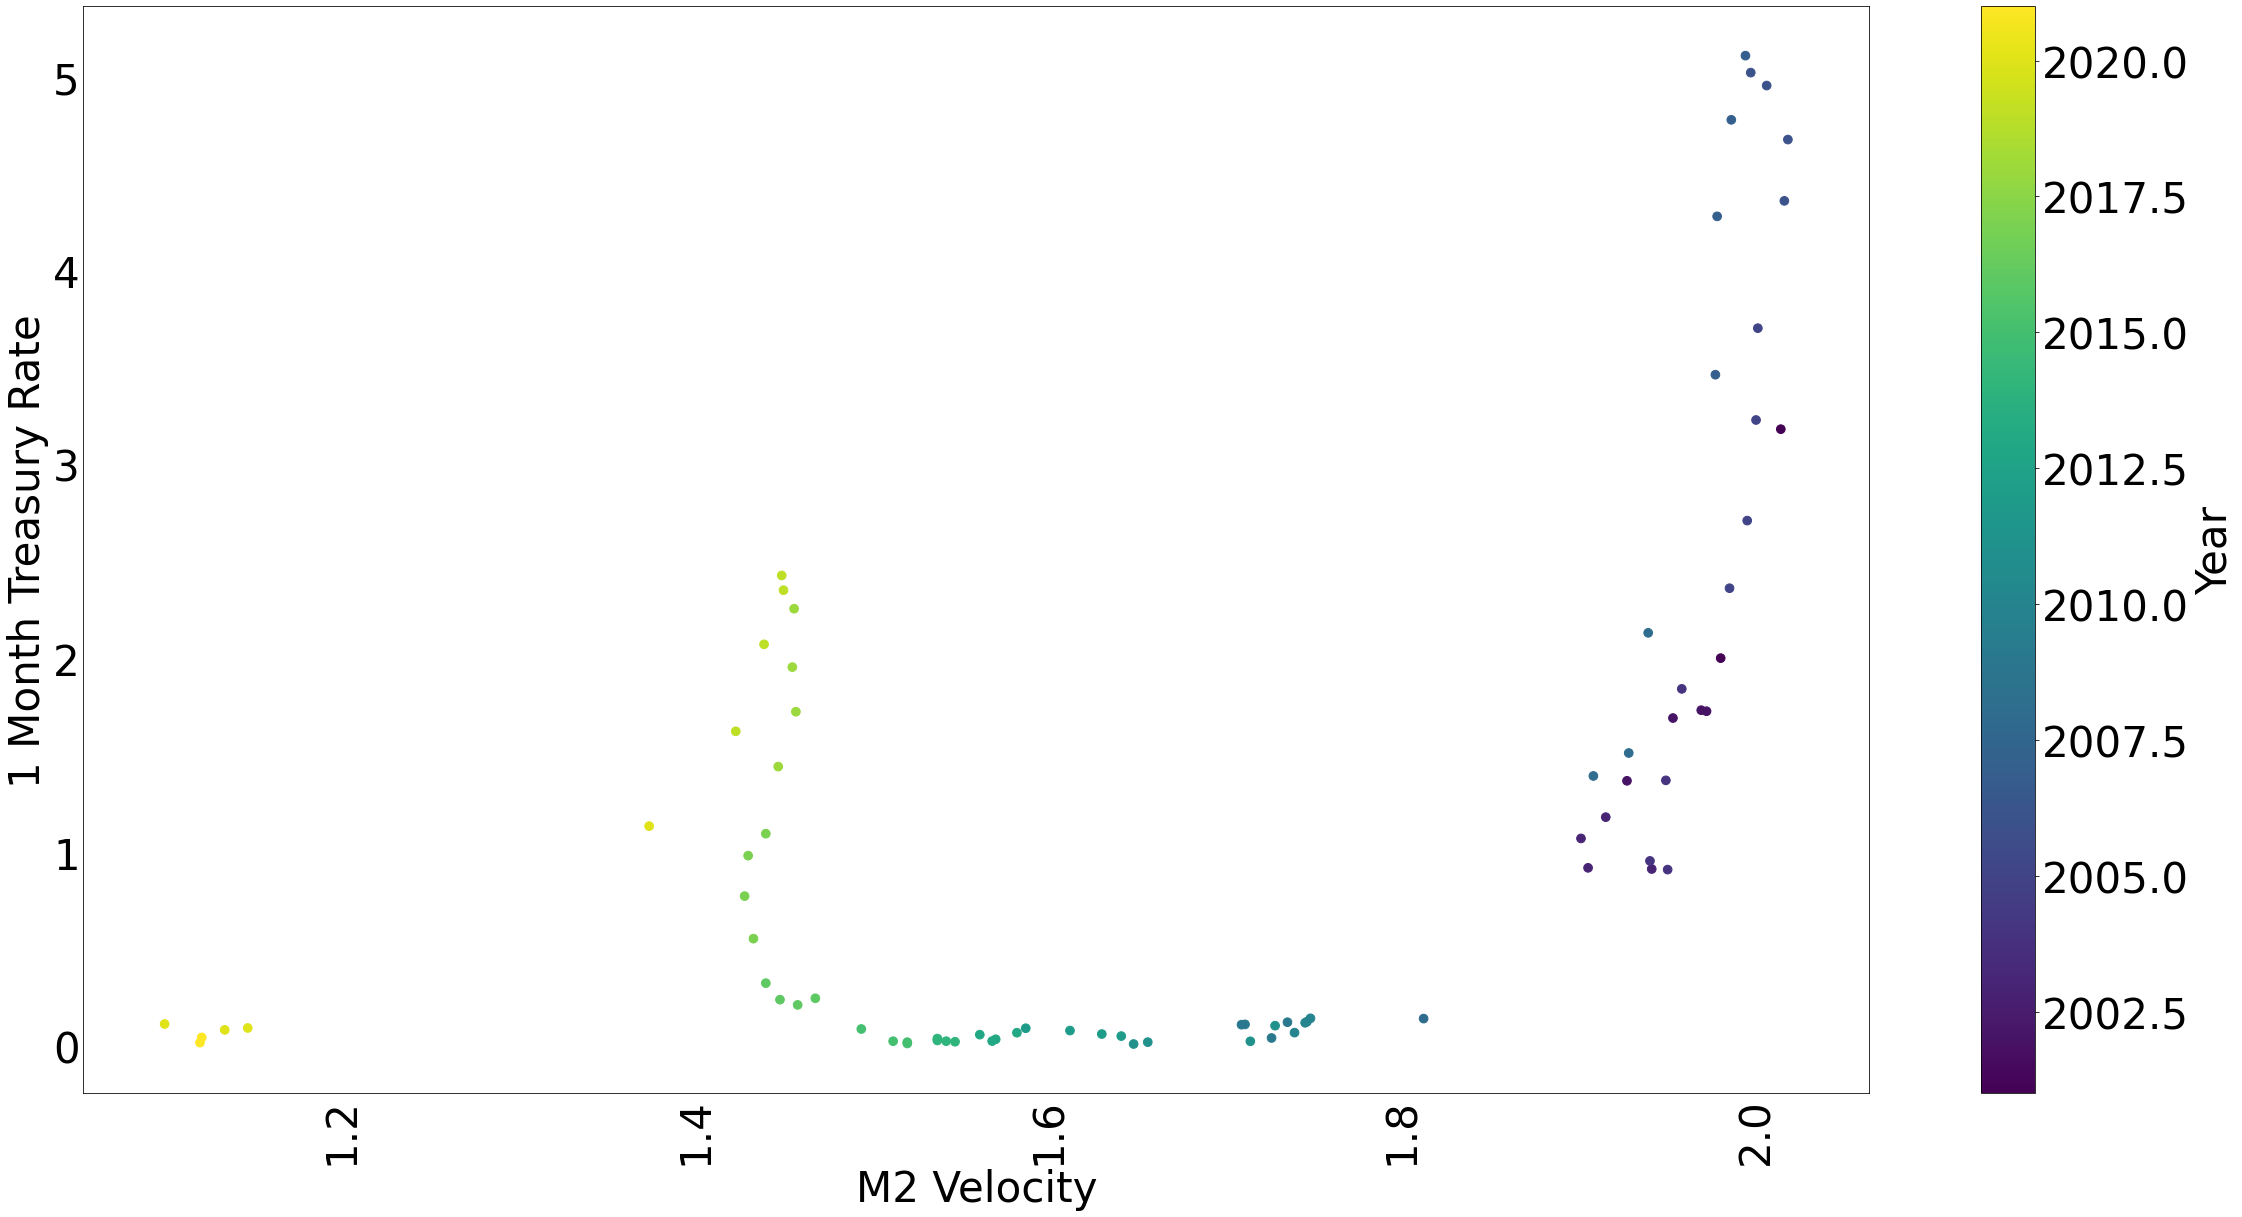

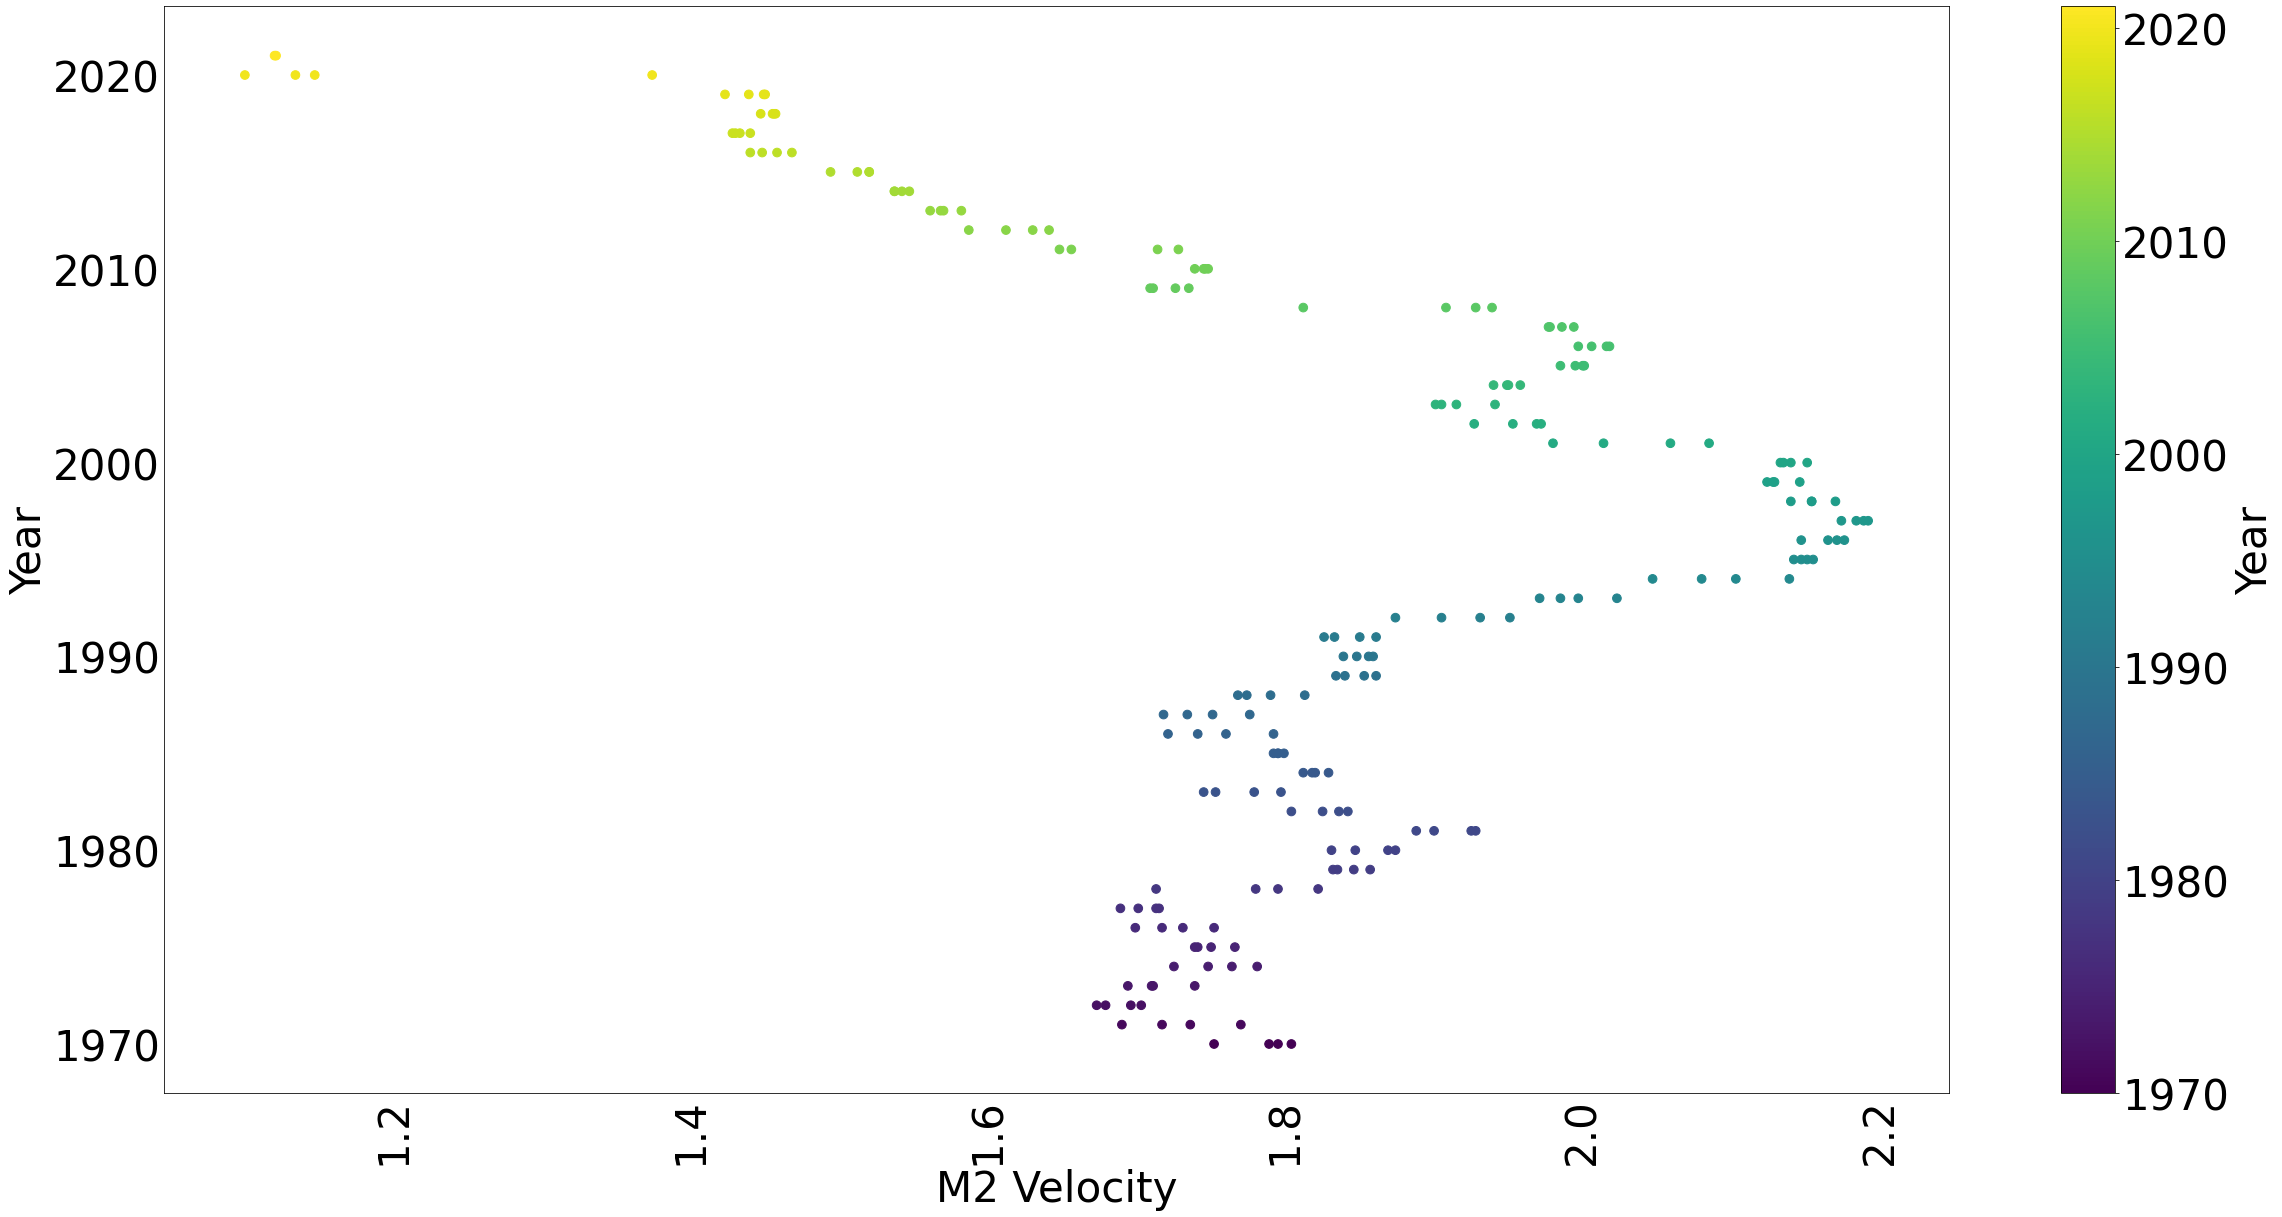

In [14]:
plot_keys = ["1 Month Treasury Rate", "M2 Velocity"]
plot_df = df[plot_keys]
plot_scatter(plot_df)

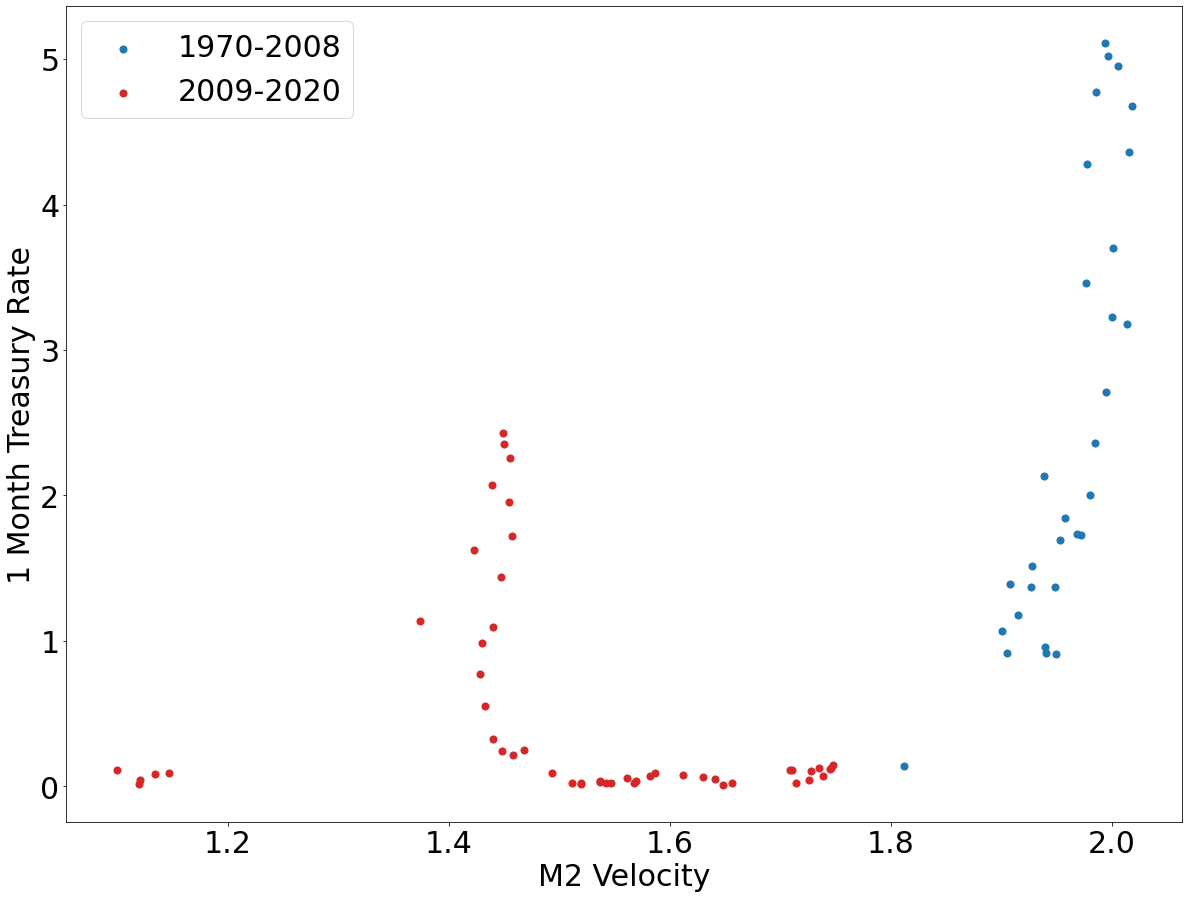

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30}) 
x = plot_keys[1]
y = plot_keys[0]
plot_df1 = df[plot_keys].loc[:"2008"]
plot_df2 = df[plot_keys].loc["2009":]
fig, ax = plt.subplots(figsize = (20, 15))
plot_df1.plot.scatter(x = x, y = y, s = 50, 
                      c = "C0", ax = ax, label = "1970-2008")
plot_df2.plot.scatter(x = x, y = y, s = 50, 
                      c = "C3", ax = ax, label = "2009-2020")

plt.legend()
plt.show()
plt.close()

plot_df.to_csv("M2AndM2VelocityData.csv")

In [16]:
df[plot_keys].corr()

,1 Month Treasury Rate,M2 Velocity
1 Month Treasury Rate,1.000000,0.574149
M2 Velocity,0.574149,1.000000


In [17]:
plot_df1.corr()

,1 Month Treasury Rate,M2 Velocity
1 Month Treasury Rate,1.000000,0.787285
M2 Velocity,0.787285,1.000000


In [18]:
plot_df2.corr()

,1 Month Treasury Rate,M2 Velocity
1 Month Treasury Rate,1.000000,-0.233007
M2 Velocity,-0.233007,1.000000
